In [1]:
#!/usr/bin/env python3
"""
Generalized exploration script for Navier-Stokes VTK data
Works with different Reynolds numbers and simulation configurations
"""

import vtk
import numpy as np
from pathlib import Path
import re

def explore_karman_simulation(data_dir):
    """
    Explore any Kármán vortex street simulation directory
    
    Parameters:
    -----------
    data_dir : str or Path
        Path to simulation directory (e.g., Reynolds_20, Reynolds_100)
    """
    data_dir = Path(data_dir)
    vtk_dir = data_dir / "VTK"
    
    # Auto-detect Reynolds number and file pattern
    re_match = re.search(r'Reynolds_(\d+)', str(data_dir))
    if re_match:
        reynolds_number = int(re_match.group(1))
        file_prefix = f"Reynolds{reynolds_number}"
    else:
        reynolds_number = "Unknown"
        file_prefix = "Unknown"
    
    print(f"🔍 Exploring Kármán Vortex Street Data (Re={reynolds_number})")
    print("=" * 60)
    
    # Find first timestep directory
    if not vtk_dir.exists():
        print(f"❌ VTK directory not found: {vtk_dir}")
        return
    
    timestep_dirs = [d for d in vtk_dir.iterdir() if d.is_dir()]
    if not timestep_dirs:
        print(f"❌ No timestep directories found in {vtk_dir}")
        return
    
    # Find first timestep with the detected pattern
    first_timestep = None
    for d in sorted(timestep_dirs):
        if d.name.startswith(file_prefix) or d.name.startswith("Reynolds"):
            first_timestep = d
            break
    
    if not first_timestep:
        # Fallback to first available directory
        first_timestep = sorted(timestep_dirs)[0]
        print(f"⚠️  Using fallback timestep directory: {first_timestep.name}")
    
    internal_mesh = first_timestep / "internal.vtu"
    
    if not internal_mesh.exists():
        print(f"❌ Internal mesh file not found: {internal_mesh}")
        return
    
    # Load the mesh
    reader = vtk.vtkXMLUnstructuredGridReader()
    reader.SetFileName(str(internal_mesh))
    reader.Update()
    mesh = reader.GetOutput()
    
    # Basic mesh info
    print(f"📐 Mesh Statistics:")
    print(f"   • Nodes (points): {mesh.GetNumberOfPoints():,}")
    print(f"   • Cells: {mesh.GetNumberOfCells():,}")
    
    # Get coordinate bounds
    bounds = mesh.GetBounds()
    print(f"   • Domain: x=[{bounds[0]:.2f}, {bounds[1]:.2f}], "
          f"y=[{bounds[2]:.2f}, {bounds[3]:.2f}], z=[{bounds[4]:.2f}, {bounds[5]:.2f}]")
    
    # Determine if 2D or 3D
    z_thickness = bounds[5] - bounds[4]
    if z_thickness < 0.02:  # Less than 2cm thick
        print(f"   • Flow type: 2D (z-thickness = {z_thickness:.4f}m)")
    else:
        print(f"   • Flow type: 3D")
    
    # Analyze solution fields
    point_data = mesh.GetPointData()
    cell_data = mesh.GetCellData()
    
    print(f"\n🌊 Flow Solution Fields:")
    
    # Point data (node-centered)
    if point_data.GetNumberOfArrays() > 0:
        print("   Node-centered variables:")
        for i in range(point_data.GetNumberOfArrays()):
            array = point_data.GetArray(i)
            name = array.GetName()
            n_comp = array.GetNumberOfComponents()
            
            if n_comp == 1:
                data_range = array.GetRange()
                print(f"     • {name}: scalar, range=[{data_range[0]:.3e}, {data_range[1]:.3e}]")
            else:
                print(f"     • {name}: vector ({n_comp}D)")
                # For vectors, show magnitude range
                try:
                    calc = vtk.vtkArrayCalculator()
                    calc.SetInputData(mesh)
                    calc.SetAttributeTypeToPointData()
                    calc.AddVectorVariable("vec", name)
                    calc.SetFunction("mag(vec)")
                    calc.SetResultArrayName("magnitude")
                    calc.Update()
                    mag_array = calc.GetOutput().GetPointData().GetArray("magnitude")
                    if mag_array:
                        mag_range = mag_array.GetRange()
                        print(f"       magnitude range=[{mag_range[0]:.3e}, {mag_range[1]:.3e}]")
                except:
                    print(f"       magnitude: could not compute")
    
    # Cell data (cell-centered)
    if cell_data.GetNumberOfArrays() > 0:
        print("   Cell-centered variables:")
        for i in range(cell_data.GetNumberOfArrays()):
            array = cell_data.GetArray(i)
            name = array.GetName()
            n_comp = array.GetNumberOfComponents()
            
            if n_comp == 1:
                data_range = array.GetRange()
                print(f"     • {name}: scalar, range=[{data_range[0]:.3e}, {data_range[1]:.3e}]")
            else:
                print(f"     • {name}: vector ({n_comp}D)")
    
    # Count available timesteps - generalized pattern matching
    timestep_patterns = [f"{file_prefix}_*", "Reynolds*_*", "*_*"]
    timestep_numbers = []
    
    for pattern in timestep_patterns:
        matching_dirs = [d for d in vtk_dir.iterdir() 
                        if d.is_dir() and d.name != "." and d.name != ".."]
        
        for d in matching_dirs:
            # Try to extract timestep number from directory name
            timestep_match = re.search(r'_(\d+)$', d.name)
            if timestep_match:
                timestep_numbers.append(int(timestep_match.group(1)))
        
        if timestep_numbers:  # If we found timesteps, break
            break
    
    timestep_numbers = sorted(list(set(timestep_numbers)))  # Remove duplicates
    
    print(f"\n⏰ Temporal Data:")
    print(f"   • Available timesteps: {len(timestep_numbers)}")
    if timestep_numbers:
        print(f"   • Time range: {min(timestep_numbers)} to {max(timestep_numbers)}")
        if len(timestep_numbers) > 1:
            increment = timestep_numbers[1] - timestep_numbers[0]
            print(f"   • Time increment: {increment}")
        
        # Estimate physical time if possible
        if len(timestep_numbers) > 1:
            print(f"   • Suitable for temporal GNN training: ✅")
        else:
            print(f"   • Suitable for temporal GNN training: ❌ (need multiple timesteps)")
    
    # Check boundary data
    boundary_dir = first_timestep / "boundary"
    if boundary_dir.exists():
        boundary_files = list(boundary_dir.glob("*.vtp"))
        print(f"\n🔲 Boundary Data:")
        print(f"   • Boundary patches: {len(boundary_files)}")
        for bf in boundary_files:
            print(f"     • {bf.stem}")
    
    # Simulation info from other files (generalized naming)
    additional_files = []
    if (data_dir / "metadata.txt").exists():
        additional_files.append("metadata.txt (simulation info)")
    
    # Look for oscillation/force data with flexible naming
    csv_files = list(data_dir.glob("*oscillat*.csv"))
    csv_files.extend(list(data_dir.glob("*force*.csv")))
    csv_files.extend(list(data_dir.glob("*lift*.csv")))
    for csv_file in csv_files:
        additional_files.append(f"{csv_file.name} (force/lift data)")
    
    # Look for probe data
    probe_files = list(data_dir.glob("*probe*.csv"))
    for probe_file in probe_files:
        additional_files.append(f"{probe_file.name} (probe data)")
    
    if additional_files:
        print(f"\n📋 Additional Files Available:")
        for file_desc in additional_files:
            print(f"   • {file_desc}")
    
    # Flow physics assessment
    print(f"\n🌊 Flow Physics Assessment:")
    
    # Estimate vortex shedding based on Reynolds number
    if isinstance(reynolds_number, int):
        if reynolds_number < 40:
            print(f"   • Flow regime: Steady separated flow")
            print(f"   • Vortex shedding: Not expected")
        elif reynolds_number < 200:
            print(f"   • Flow regime: Periodic vortex shedding")
            print(f"   • Vortex shedding: Expected (Kármán vortex street)")
        else:
            print(f"   • Flow regime: Turbulent wake")
            print(f"   • Vortex shedding: Complex/turbulent")
    
    # GNN readiness assessment
    print(f"\n✅ PyTorch Geometric Conversion Readiness:")
    print(f"   • Mesh size: {'✅ Good' if mesh.GetNumberOfPoints() > 1000 else '⚠️ Small'}")
    print(f"   • Temporal data: {'✅ Available' if len(timestep_numbers) > 10 else '⚠️ Limited'}")
    print(f"   • Flow fields: {'✅ Complete' if point_data.GetNumberOfArrays() >= 3 else '⚠️ Minimal'}")
    print(f"   • Ready for GNN training: {'✅ Yes' if len(timestep_numbers) > 10 and mesh.GetNumberOfPoints() > 1000 else '⚠️ Check requirements'}")
    
    print(f"\n🚀 Next Steps:")
    print(f"   • Use: converter = GeneralizedVTKConverter('{data_dir}')")
    print(f"   • Convert: data = converter.to_pytorch_geometric(timestep=0)")
    print(f"   • Dataset: dataset = converter.create_temporal_dataset()")
    if reynolds_number != "Unknown":
        print(f"   • Animation: Skip first ~50 timesteps for Re={reynolds_number} (startup transient)")

def explore_multiple_simulations(base_dir):
    """Explore multiple Reynolds number simulations in a base directory"""
    base_dir = Path(base_dir)
    
    print(f"🔍 Exploring Multiple Simulations in: {base_dir}")
    print("=" * 70)
    
    # Find all Reynolds_* directories
    reynolds_dirs = list(base_dir.glob("Reynolds_*"))
    if not reynolds_dirs:
        print("❌ No Reynolds_* directories found")
        return
    
    reynolds_dirs.sort()
    
    for re_dir in reynolds_dirs:
        print(f"\n{'='*60}")
        explore_karman_simulation(re_dir)
        print(f"{'='*60}")

def quick_explore_karman_data(data_dir=None):
    """
    Quick exploration function that accepts data directory as parameter
    
    Parameters:
    -----------
    data_dir : str or Path, optional
        Path to simulation directory. If None, uses default Reynolds_100 path
    """
    
    # Set default if not provided
    if data_dir is None:
        data_dir = Path("/standard/sds_baek_energetic/G-PARC/Kármán vortex street/Reynolds_100")
    else:
        data_dir = Path(data_dir)
    
    # Use the main exploration function
    explore_karman_simulation(data_dir)
    import sys
    
    if len(sys.argv) > 1:
        data_dir = sys.argv[1]
        explore_karman_simulation(data_dir)
    else:
        print("Usage:")
        print("  python explore_simulation.py /path/to/Reynolds_100")
        print("  or:")
        print("  explore_karman_simulation('/path/to/Reynolds_100')")
        print("  explore_multiple_simulations('/path/to/base/directory')")

In [14]:
quick_explore_karman_data("/standard/sds_baek_energetic/G-PARC/Kármán vortex street/Reynolds_20")

🔍 Exploring Kármán Vortex Street Data (Re=20)
📐 Mesh Statistics:
   • Nodes (points): 60,746
   • Cells: 29,938
   • Domain: x=[-0.05, 0.15], y=[-0.05, 0.05], z=[0.00, 0.01]
   • Flow type: 2D (z-thickness = 0.0100m)

🌊 Flow Solution Fields:
   Node-centered variables:
     • p: scalar, range=[0.000e+00, 0.000e+00]
     • U: vector (3D)
       magnitude range=[0.000e+00, 3.020e-02]
     • vorticity: vector (3D)
       magnitude range=[0.000e+00, 1.656e+02]
   Cell-centered variables:
     • p: scalar, range=[0.000e+00, 0.000e+00]
     • U: vector (3D)
     • vorticity: vector (3D)

⏰ Temporal Data:
   • Available timesteps: 201
   • Time range: 0 to 5000
   • Time increment: 25
   • Suitable for temporal GNN training: ✅

🔲 Boundary Data:
   • Boundary patches: 4
     • boundaries
     • outlet
     • inlet
     • cylinder_1

📋 Additional Files Available:
   • metadata.txt (simulation info)
   • probe_centerline_u.csv (probe data)

🌊 Flow Physics Assessment:
   • Flow regime: Steady sep

In [2]:
import vtk
import numpy as np
import torch
from torch_geometric.data import Data
from pathlib import Path
import glob
import re

class GeneralizedVTKConverter:
    """
    Generalized converter for OpenFOAM VTK output to PyTorch Geometric format
    Works with different Reynolds numbers and simulation configurations
    """
    
    def __init__(self, data_dir, auto_detect=True):
        """
        Initialize converter
        
        Parameters:
        -----------
        data_dir : str or Path
            Root directory containing simulation data
        auto_detect : bool
            If True, automatically detect simulation parameters
        """
        self.data_dir = Path(data_dir)
        self.vtk_dir = self.data_dir / "VTK"
        
        # Auto-detect simulation parameters
        if auto_detect:
            self._detect_simulation_config()
        
        self.timesteps = self._get_timesteps()
        
    def _detect_simulation_config(self):
        """Auto-detect simulation configuration from directory structure"""
        print(f"🔍 Auto-detecting simulation configuration...")
        
        # Extract Reynolds number from directory name
        re_match = re.search(r'Reynolds_(\d+)', str(self.data_dir))
        if re_match:
            self.reynolds_number = int(re_match.group(1))
        else:
            # Try to find from file patterns
            vtk_files = list(self.vtk_dir.glob("*.vtm"))
            if vtk_files:
                file_pattern = vtk_files[0].stem
                re_match = re.search(r'Reynolds(\d+)', file_pattern)
                if re_match:
                    self.reynolds_number = int(re_match.group(1))
                else:
                    self.reynolds_number = None
            else:
                self.reynolds_number = None
        
        # Detect file naming pattern
        vtm_files = list(self.vtk_dir.glob("*.vtm"))
        if vtm_files:
            sample_file = vtm_files[0].stem
            if "Reynolds" in sample_file:
                # Extract the pattern (e.g., "Reynolds20", "Reynolds100")
                pattern_match = re.match(r'(Reynolds\d+)', sample_file)
                if pattern_match:
                    self.file_prefix = pattern_match.group(1)
                else:
                    self.file_prefix = "Reynolds"
            else:
                self.file_prefix = sample_file.split('_')[0]
        else:
            self.file_prefix = "Reynolds"
        
        # Detect mesh type and domain info
        self._analyze_mesh_structure()
        
        print(f"  Reynolds number: {self.reynolds_number}")
        print(f"  File prefix: {self.file_prefix}")
        print(f"  Domain bounds: {getattr(self, 'domain_bounds', 'Not detected')}")
        
    def _get_timesteps(self):
        """Extract available timesteps from VTK directory"""
        # Handle different file naming patterns
        patterns = [
            f"{self.file_prefix}_*.vtm",
            "*.vtm"
        ]
        
        timesteps = []
        for pattern in patterns:
            vtm_files = glob.glob(str(self.vtk_dir / pattern))
            
            for f in vtm_files:
                if "series" not in f:  # Skip series files
                    # Try to extract timestep number from filename
                    filename = Path(f).stem
                    
                    # Common patterns: Reynolds20_1000, simulation_1000, etc.
                    timestep_match = re.search(r'_(\d+)$', filename)
                    if timestep_match:
                        timesteps.append(int(timestep_match.group(1)))
            
            if timesteps:  # If we found timesteps with this pattern, use it
                break
        
        return sorted(list(set(timesteps)))  # Remove duplicates and sort
    
    def _analyze_mesh_structure(self):
        """Analyze mesh structure from first available timestep"""
        if not self.vtk_dir.exists():
            print(f"  VTK directory not found: {self.vtk_dir}")
            return
            
        # Find first timestep directory
        timestep_dirs = [d for d in self.vtk_dir.iterdir() if d.is_dir()]
        if not timestep_dirs:
            print(f"  No timestep directories found")
            return
        
        first_dir = sorted(timestep_dirs)[0]
        internal_file = first_dir / "internal.vtu"
        
        if not internal_file.exists():
            print(f"  Internal mesh file not found")
            return
        
        try:
            reader = vtk.vtkXMLUnstructuredGridReader()
            reader.SetFileName(str(internal_file))
            reader.Update()
            mesh = reader.GetOutput()
            
            # Store mesh info
            self.n_points = mesh.GetNumberOfPoints()
            self.n_cells = mesh.GetNumberOfCells()
            self.domain_bounds = mesh.GetBounds()
            
            # Analyze available fields
            point_data = mesh.GetPointData()
            self.available_fields = []
            for i in range(point_data.GetNumberOfArrays()):
                array = point_data.GetArray(i)
                self.available_fields.append({
                    'name': array.GetName(),
                    'components': array.GetNumberOfComponents(),
                    'type': 'point'
                })
            
        except Exception as e:
            print(f"  Error analyzing mesh: {e}")
    
    def _get_cell_edges(self, cell_type, point_ids):
        """Get edges for different cell types"""
        edges = []
        
        if cell_type == 12:  # Hexahedron
            edges = [
                # Bottom face
                [point_ids[0], point_ids[1]], [point_ids[1], point_ids[2]], 
                [point_ids[2], point_ids[3]], [point_ids[3], point_ids[0]],
                # Top face  
                [point_ids[4], point_ids[5]], [point_ids[5], point_ids[6]], 
                [point_ids[6], point_ids[7]], [point_ids[7], point_ids[4]],
                # Vertical edges
                [point_ids[0], point_ids[4]], [point_ids[1], point_ids[5]], 
                [point_ids[2], point_ids[6]], [point_ids[3], point_ids[7]]
            ]
        elif cell_type == 13:  # Wedge
            edges = [
                [point_ids[0], point_ids[1]], [point_ids[1], point_ids[2]], [point_ids[2], point_ids[0]],
                [point_ids[3], point_ids[4]], [point_ids[4], point_ids[5]], [point_ids[5], point_ids[3]],
                [point_ids[0], point_ids[3]], [point_ids[1], point_ids[4]], [point_ids[2], point_ids[5]]
            ]
        else:  # Polyhedron and others - connect all pairs
            for i in range(len(point_ids)):
                for j in range(i + 1, len(point_ids)):
                    edges.append([point_ids[i], point_ids[j]])
        
        return edges
    
    def _extract_mesh_connectivity(self, mesh):
        """Extract mesh connectivity from VTK cells"""
        edge_set = set()
        n_cells = mesh.GetNumberOfCells()
        
        for i in range(n_cells):
            cell = mesh.GetCell(i)
            cell_type = cell.GetCellType()
            n_points = cell.GetNumberOfPoints()
            
            point_ids = [cell.GetPointId(j) for j in range(n_points)]
            edges = self._get_cell_edges(cell_type, point_ids)
            
            for edge in edges:
                edge_set.add(tuple(sorted(edge)))
                
        # Convert to directed edges
        directed_edges = []
        for edge in edge_set:
            directed_edges.append([edge[0], edge[1]])
            directed_edges.append([edge[1], edge[0]])
        
        return np.array(directed_edges).T if directed_edges else np.array([[], []])
    
    def to_pytorch_geometric(self, timestep, include_derived_features=True, 
                           cylinder_center=None):
        """
        Convert timestep to PyTorch Geometric Data
        
        Parameters:
        -----------
        timestep : int
            Timestep number
        include_derived_features : bool
            Whether to add derived features like velocity magnitude
        cylinder_center : tuple or None
            Cylinder center coordinates (auto-detected if None)
        """
        # Find timestep directory
        timestep_dir = self.vtk_dir / f"{self.file_prefix}_{timestep}"
        internal_file = timestep_dir / "internal.vtu"
        
        if not internal_file.exists():
            raise FileNotFoundError(f"Internal mesh file not found: {internal_file}")
        
        # Load mesh
        reader = vtk.vtkXMLUnstructuredGridReader()
        reader.SetFileName(str(internal_file))
        reader.Update()
        mesh = reader.GetOutput()
        
        # Extract positions
        points = mesh.GetPoints()
        pos = np.array([points.GetPoint(i) for i in range(points.GetNumberOfPoints())])
        
        # Extract connectivity
        edge_index = self._extract_mesh_connectivity(mesh)
        
        # Extract features
        point_data = mesh.GetPointData()
        features = []
        feature_names = []
        
        # Process each available field
        for i in range(point_data.GetNumberOfArrays()):
            array = point_data.GetArray(i)
            name = array.GetName()
            n_components = array.GetNumberOfComponents()
            
            if name == 'p':  # Pressure
                data = np.array([array.GetValue(j) for j in range(array.GetNumberOfTuples())])
                features.append(data.reshape(-1, 1))
                feature_names.append('pressure')
                
            elif name == 'U':  # Velocity
                data = np.array([array.GetTuple(j) for j in range(array.GetNumberOfTuples())])
                features.append(data)
                feature_names.extend(['velocity_x', 'velocity_y', 'velocity_z'])
                
            elif name == 'vorticity':  # Vorticity
                data = np.array([array.GetTuple(j) for j in range(array.GetNumberOfTuples())])
                features.append(data)
                feature_names.extend(['vorticity_x', 'vorticity_y', 'vorticity_z'])
                
            else:
                # Handle other fields generically
                if n_components == 1:
                    data = np.array([array.GetValue(j) for j in range(array.GetNumberOfTuples())])
                    features.append(data.reshape(-1, 1))
                    feature_names.append(name)
                else:
                    data = np.array([array.GetTuple(j) for j in range(array.GetNumberOfTuples())])
                    features.append(data)
                    for comp in range(n_components):
                        feature_names.append(f"{name}_{comp}")
        
        # Add derived features
        if include_derived_features:
            # Velocity magnitude
            if 'U' in [point_data.GetArray(i).GetName() for i in range(point_data.GetNumberOfArrays())]:
                velocity_array = point_data.GetArray('U')
                velocity = np.array([velocity_array.GetTuple(j) for j in range(velocity_array.GetNumberOfTuples())])
                
                vel_mag = np.linalg.norm(velocity, axis=1, keepdims=True)
                features.append(vel_mag)
                feature_names.append('velocity_magnitude')
            
            # Vorticity magnitude
            if 'vorticity' in [point_data.GetArray(i).GetName() for i in range(point_data.GetNumberOfArrays())]:
                vorticity_array = point_data.GetArray('vorticity')
                vorticity = np.array([vorticity_array.GetTuple(j) for j in range(vorticity_array.GetNumberOfTuples())])
                
                vort_mag = np.linalg.norm(vorticity, axis=1, keepdims=True)
                features.append(vort_mag)
                feature_names.append('vorticity_magnitude')
            
            # Distance from cylinder (auto-detect center if not provided)
            if cylinder_center is None:
                # Auto-detect cylinder center (assume at origin for now)
                cylinder_center = np.array([0.0, 0.0])
            
            pos_2d = pos[:, :2]
            dist_from_cylinder = np.linalg.norm(pos_2d - cylinder_center, axis=1, keepdims=True)
            features.append(dist_from_cylinder)
            feature_names.append('distance_from_cylinder')
        
        # Create tensors
        pos_tensor = torch.tensor(pos, dtype=torch.float)
        edge_index_tensor = torch.tensor(edge_index, dtype=torch.long)
        x = torch.tensor(np.concatenate(features, axis=1), dtype=torch.float)
        
        # Create PyG Data
        data = Data(
            x=x,
            pos=pos_tensor,
            edge_index=edge_index_tensor
        )
        
        # Add metadata
        data.feature_names = feature_names
        data.timestep = timestep
        data.reynolds_number = getattr(self, 'reynolds_number', None)
        
        return data
    
    def create_temporal_dataset(self, timesteps=None, save_progress=True, **kwargs):
        """Create temporal dataset with multiple timesteps"""
        if timesteps is None:
            timesteps = self.timesteps
        
        dataset = []
        print(f"Creating temporal dataset with {len(timesteps)} timesteps...")
        if hasattr(self, 'reynolds_number') and self.reynolds_number:
            print(f"Reynolds number: {self.reynolds_number}")
        
        for i, timestep in enumerate(timesteps):
            if save_progress and (i + 1) % 25 == 0:
                print(f"  Processed {i + 1}/{len(timesteps)} timesteps...")
            
            data = self.to_pytorch_geometric(timestep, **kwargs)
            dataset.append(data)
        
        print(f"✅ Complete! Created dataset with {len(dataset)} timesteps")
        return dataset
    
    def summary(self):
        """Print summary of detected simulation"""
        print(f"\n📊 Simulation Summary:")
        print(f"  Directory: {self.data_dir}")
        print(f"  Reynolds number: {getattr(self, 'reynolds_number', 'Unknown')}")
        print(f"  File prefix: {getattr(self, 'file_prefix', 'Unknown')}")
        print(f"  Available timesteps: {len(self.timesteps)}")
        if self.timesteps:
            print(f"  Time range: {min(self.timesteps)} to {max(self.timesteps)}")
        print(f"  Mesh size: {getattr(self, 'n_points', 'Unknown')} points, {getattr(self, 'n_cells', 'Unknown')} cells")
        if hasattr(self, 'available_fields'):
            print(f"  Available fields: {[f['name'] for f in self.available_fields]}")

# Convenience function for quick usage
def load_karman_simulation(data_dir):
    """Quickly load and analyze a Kármán vortex street simulation"""
    converter = GeneralizedVTKConverter(data_dir)
    converter.summary()
    return converter

# Usage examples
if __name__ == "__main__":
    print("Generalized VTK to PyTorch Geometric Converter")
    print("\nUsage:")
    print("  converter = GeneralizedVTKConverter('/path/to/simulation')")
    print("  converter.summary()")
    print("  data = converter.to_pytorch_geometric(timestep=0)")
    print("  dataset = converter.create_temporal_dataset()")

/home/jtb3sud/.local/lib/python3.10/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /home/jtb3sud/.local/lib/python3.10/site-packages/torch_scatter/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "


Generalized VTK to PyTorch Geometric Converter

Usage:
  converter = GeneralizedVTKConverter('/path/to/simulation')
  converter.summary()
  data = converter.to_pytorch_geometric(timestep=0)
  dataset = converter.create_temporal_dataset()


In [3]:
re20_converter = GeneralizedVTKConverter("/standard/sds_baek_energetic/G-PARC/Kármán vortex street/Reynolds_20")
re20_converter.summary()
re20_data = re20_converter.to_pytorch_geometric(timestep=0)

🔍 Auto-detecting simulation configuration...
  Reynolds number: 20
  File prefix: Reynolds20
  Domain bounds: (-0.05000000074505806, 0.15000000596046448, -0.05000000074505806, 0.05000000074505806, 0.0, 0.009999999776482582)

📊 Simulation Summary:
  Directory: /standard/sds_baek_energetic/G-PARC/Kármán vortex street/Reynolds_20
  Reynolds number: 20
  File prefix: Reynolds20
  Available timesteps: 201
  Time range: 0 to 5000
  Mesh size: 60746 points, 29938 cells
  Available fields: ['p', 'U', 'vorticity']


In [4]:
re100_converter = GeneralizedVTKConverter("/standard/sds_baek_energetic/G-PARC/Kármán vortex street/Reynolds_100")
re100_converter.summary()
re100_data = re100_converter.to_pytorch_geometric(timestep=0)

🔍 Auto-detecting simulation configuration...
  Reynolds number: 100
  File prefix: Reynolds100
  Domain bounds: (-0.05000000074505806, 0.15000000596046448, -0.05000000074505806, 0.05000000074505806, 0.0, 0.009999999776482582)

📊 Simulation Summary:
  Directory: /standard/sds_baek_energetic/G-PARC/Kármán vortex street/Reynolds_100
  Reynolds number: 100
  File prefix: Reynolds100
  Available timesteps: 201
  Time range: 0 to 5000
  Mesh size: 60746 points, 29938 cells
  Available fields: ['p', 'U', 'vorticity']


In [18]:
# Load both simulations
re20_conv = GeneralizedVTKConverter("/standard/sds_baek_energetic/G-PARC/Kármán vortex street/Reynolds_20")
re100_conv = GeneralizedVTKConverter("/standard/sds_baek_energetic/G-PARC/Kármán vortex street/Reynolds_100")

# Compare first timesteps
re20_data = re20_conv.to_pytorch_geometric(timestep=0)
re100_data = re100_conv.to_pytorch_geometric(timestep=0)

print(f"Re=20: {re20_data.reynolds_number}, nodes: {re20_data.num_nodes}")
print(f"Re=100: {re100_data.reynolds_number}, nodes: {re100_data.num_nodes}")

🔍 Auto-detecting simulation configuration...
  Reynolds number: 20
  File prefix: Reynolds20
  Domain bounds: (-0.05000000074505806, 0.15000000596046448, -0.05000000074505806, 0.05000000074505806, 0.0, 0.009999999776482582)
🔍 Auto-detecting simulation configuration...
  Reynolds number: 100
  File prefix: Reynolds100
  Domain bounds: (-0.05000000074505806, 0.15000000596046448, -0.05000000074505806, 0.05000000074505806, 0.0, 0.009999999776482582)
Re=20: 20, nodes: 60746
Re=100: 100, nodes: 60746


In [24]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from matplotlib.colors import Normalize
from matplotlib.patches import Circle
import matplotlib.animation as animation

def visualize_karman_data(dataset, save_plots=True, reynolds_number=None):
    """
    Visualize Kármán vortex street data from PyTorch Geometric dataset
    Works with any Reynolds number simulation
    """
    
    print("🎨 Creating Kármán Vortex Street Visualizations...")
    
    # Handle both single Data object and list of Data objects
    if not isinstance(dataset, list):
        data = dataset
    else:
        data = dataset[0]
    
    # Auto-detect Reynolds number if not provided
    if reynolds_number is None:
        reynolds_number = getattr(data, 'reynolds_number', 'Unknown')
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle(f'Kármán Vortex Street - Flow Analysis (Re={reynolds_number})', 
                 fontsize=16, fontweight='bold')
    pos_2d = data.pos[:, :2].numpy()
    
    # Extract feature indices
    feature_map = {name: i for i, name in enumerate(data.feature_names)}
    
    # Detect cylinder center from distance feature if available
    if 'distance_from_cylinder' in feature_map:
        dist_field = data.x[:, feature_map['distance_from_cylinder']].numpy()
        min_dist_idx = np.argmin(dist_field)
        cylinder_center = pos_2d[min_dist_idx]
        cylinder_radius = np.min(dist_field)
    else:
        # Default assumption
        cylinder_center = (0.0, 0.0)
        cylinder_radius = 0.005
    
    # Plot 1: Velocity Magnitude
    ax = axes[0, 0]
    if 'velocity_magnitude' in feature_map:
        vel_mag = data.x[:, feature_map['velocity_magnitude']].numpy()
        scatter1 = ax.scatter(pos_2d[:, 0], pos_2d[:, 1], c=vel_mag, 
                             cmap='viridis', s=0.3, alpha=0.8)
        plt.colorbar(scatter1, ax=ax, label='Velocity Magnitude (m/s)')
        ax.set_title(f'Velocity Field (t={data.timestep})')
    else:
        ax.text(0.5, 0.5, 'Velocity Magnitude\nNot Available', 
                transform=ax.transAxes, ha='center', va='center')
        ax.set_title('Velocity Field - N/A')
    
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')
    ax.set_aspect('equal')
    
    # Plot 2: Vorticity Magnitude  
    ax = axes[0, 1]
    if 'vorticity_magnitude' in feature_map:
        vort_mag = data.x[:, feature_map['vorticity_magnitude']].numpy()
        # Use log scale for vorticity to see structures better
        vort_mag_log = np.log10(vort_mag + 1e-10)
        scatter2 = ax.scatter(pos_2d[:, 0], pos_2d[:, 1], c=vort_mag_log, 
                             cmap='RdBu_r', s=0.3, alpha=0.8)
        plt.colorbar(scatter2, ax=ax, label='log₁₀(Vorticity Magnitude)')
        ax.set_title(f'Vorticity Field (t={data.timestep})')
    else:
        ax.text(0.5, 0.5, 'Vorticity Magnitude\nNot Available', 
                transform=ax.transAxes, ha='center', va='center')
        ax.set_title('Vorticity Field - N/A')
    
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')
    ax.set_aspect('equal')
    
    # Plot 3: Velocity Vectors (sampled)
    ax = axes[0, 2]
    if all(f in feature_map for f in ['velocity_x', 'velocity_y', 'velocity_magnitude']):
        sample_idx = np.arange(0, len(pos_2d), 100)
        pos_sample = pos_2d[sample_idx]
        vel_x = data.x[sample_idx, feature_map['velocity_x']].numpy()
        vel_y = data.x[sample_idx, feature_map['velocity_y']].numpy()
        vel_mag_sample = data.x[sample_idx, feature_map['velocity_magnitude']].numpy()
        
        quiver = ax.quiver(pos_sample[:, 0], pos_sample[:, 1], vel_x, vel_y, 
                          vel_mag_sample, cmap='plasma', scale=0.5, alpha=0.7)
        plt.colorbar(quiver, ax=ax, label='Velocity Magnitude (m/s)')
        ax.set_title('Velocity Vectors')
    else:
        ax.text(0.5, 0.5, 'Velocity Components\nNot Available', 
                transform=ax.transAxes, ha='center', va='center')
        ax.set_title('Velocity Vectors - N/A')
    
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')
    ax.set_aspect('equal')
    
    # Plot 4: Distance from Cylinder or Pressure
    ax = axes[1, 0]
    if 'distance_from_cylinder' in feature_map:
        dist_cyl = data.x[:, feature_map['distance_from_cylinder']].numpy()
        scatter3 = ax.scatter(pos_2d[:, 0], pos_2d[:, 1], c=dist_cyl, 
                             cmap='copper', s=0.3, alpha=0.8)
        plt.colorbar(scatter3, ax=ax, label='Distance from Cylinder (m)')
        ax.set_title('Distance Field')
    elif 'pressure' in feature_map:
        pressure = data.x[:, feature_map['pressure']].numpy()
        if np.any(pressure != 0):  # Only plot if pressure is non-zero
            scatter3 = ax.scatter(pos_2d[:, 0], pos_2d[:, 1], c=pressure, 
                                 cmap='coolwarm', s=0.3, alpha=0.8)
            plt.colorbar(scatter3, ax=ax, label='Pressure (Pa)')
            ax.set_title('Pressure Field')
        else:
            ax.text(0.5, 0.5, 'Pressure Field\n(All Zero)', 
                    transform=ax.transAxes, ha='center', va='center')
            ax.set_title('Pressure Field - Zero')
    else:
        ax.text(0.5, 0.5, 'Additional Field\nNot Available', 
                transform=ax.transAxes, ha='center', va='center')
        ax.set_title('Additional Field - N/A')
    
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')
    ax.set_aspect('equal')
    
    # Plot 5: Vorticity Z-component (main component for 2D flow)
    ax = axes[1, 1]
    if 'vorticity_z' in feature_map:
        vort_z = data.x[:, feature_map['vorticity_z']].numpy()
        if np.any(vort_z != 0):
            scatter4 = ax.scatter(pos_2d[:, 0], pos_2d[:, 1], c=vort_z, 
                                 cmap='RdBu_r', s=0.3, alpha=0.8, 
                                 vmin=-np.percentile(np.abs(vort_z), 95), 
                                 vmax=np.percentile(np.abs(vort_z), 95))
            plt.colorbar(scatter4, ax=ax, label='Vorticity Z (1/s)')
            ax.set_title('Vorticity Z-component')
        else:
            ax.text(0.5, 0.5, 'Vorticity Z\n(All Zero)', 
                    transform=ax.transAxes, ha='center', va='center')
            ax.set_title('Vorticity Z - Zero')
    else:
        ax.text(0.5, 0.5, 'Vorticity Z\nNot Available', 
                transform=ax.transAxes, ha='center', va='center')
        ax.set_title('Vorticity Z - N/A')
    
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')
    ax.set_aspect('equal')
    
    # Plot 6: Graph connectivity sample
    ax = axes[1, 2]
    center_region = (np.abs(pos_2d[:, 0] - cylinder_center[0]) < 0.01) & \
                   (np.abs(pos_2d[:, 1] - cylinder_center[1]) < 0.01)
    region_nodes = np.where(center_region)[0]
    
    if len(region_nodes) > 0 and hasattr(data, 'edge_index'):
        sample_nodes = region_nodes[::max(1, len(region_nodes)//50)]
        
        ax.scatter(pos_2d[sample_nodes, 0], pos_2d[sample_nodes, 1], 
                  c='red', s=20, alpha=0.8, zorder=2)
        
        edge_index = data.edge_index.numpy()
        for i in sample_nodes:
            connected_edges = edge_index[:, edge_index[0] == i]
            for edge in connected_edges.T:
                if edge[1] in sample_nodes:
                    ax.plot([pos_2d[edge[0], 0], pos_2d[edge[1], 0]], 
                           [pos_2d[edge[0], 1], pos_2d[edge[1], 1]], 
                           'b-', alpha=0.3, linewidth=0.5)
        ax.set_title('Graph Structure (Sample)')
    else:
        ax.text(0.5, 0.5, 'Graph Structure\nNot Available', 
                transform=ax.transAxes, ha='center', va='center')
        ax.set_title('Graph Structure - N/A')
    
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')
    ax.set_aspect('equal')
    
    plt.tight_layout()
    
    if save_plots:
        filename = f'karman_vortex_analysis_re{reynolds_number}.png'
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        print(f"✅ Saved static plots as '{filename}'")
    
    plt.show()

def create_temporal_animation(dataset, feature='velocity_magnitude', save_animation=True,
                            reynolds_number=None):
    """Create animation showing temporal evolution - generalized version"""
    
    if not isinstance(dataset, list):
        print("⚠️  Single timestep provided - cannot create temporal animation")
        print("   Please provide a list of Data objects for animation")
        return
    
    # Auto-detect Reynolds number
    if reynolds_number is None:
        reynolds_number = getattr(dataset[0], 'reynolds_number', 'Unknown')
    
    print(f"🎬 Creating temporal animation for {feature} (Re={reynolds_number})...")
    
    # Check if feature exists
    if feature not in dataset[0].feature_names:
        available_features = dataset[0].feature_names
        print(f"❌ Feature '{feature}' not found.")
        print(f"Available features: {available_features}")
        return
    
    # Setup figure
    fig, ax = plt.subplots(figsize=(12, 8))
    
    data_first = dataset[0]
    pos_2d = data_first.pos[:, :2].numpy()
    feature_idx = data_first.feature_names.index(feature)
    
    # Get global min/max for consistent colormap
    all_values = []
    for data in dataset:
        values = data.x[:, feature_idx].numpy()
        all_values.extend(values)
    
    vmin, vmax = np.min(all_values), np.max(all_values)
    
    # Create initial plot
    scatter = ax.scatter(pos_2d[:, 0], pos_2d[:, 1], 
                        c=data_first.x[:, feature_idx].numpy(),
                        cmap='viridis', s=0.5, vmin=vmin, vmax=vmax)
    
    cbar = plt.colorbar(scatter, ax=ax, label=feature.replace('_', ' ').title())
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')
    ax.set_aspect('equal')
    
    # Animation function
    def animate(frame):
        data = dataset[frame]
        values = data.x[:, feature_idx].numpy()
        scatter.set_array(values)
        ax.set_title(f'Kármán Vortex Street (Re={reynolds_number}) - {feature.replace("_", " ").title()} (t={data.timestep})')
        return scatter,
    
    # Create animation
    anim = animation.FuncAnimation(fig, animate, frames=len(dataset), 
                                 interval=500, blit=False, repeat=True)
    
    if save_animation:
        filename = f'karman_vortex_{feature}_re{reynolds_number}_animation.gif'
        anim.save(filename, writer='pillow', fps=2)
        print(f"✅ Saved animation as '{filename}'")
    
    plt.show()
    return anim

def analyze_flow_statistics(dataset, reynolds_number=None):
    """Analyze flow statistics across time - generalized version"""
    
    if not isinstance(dataset, list):
        print("⚠️  Single timestep provided - cannot analyze temporal statistics")
        print("   Please provide a list of Data objects for temporal analysis")
        return
    
    # Auto-detect Reynolds number
    if reynolds_number is None:
        reynolds_number = getattr(dataset[0], 'reynolds_number', 'Unknown')
    
    print(f"📊 Analyzing flow statistics across time (Re={reynolds_number})...")
    
    # Check available features
    available_features = dataset[0].feature_names
    
    timesteps = []
    statistics = {}
    
    # Initialize statistics for available features
    for feature in ['velocity_magnitude', 'vorticity_magnitude', 'pressure']:
        if feature in available_features:
            statistics[feature] = {'mean': [], 'max': [], 'min': []}
    
    for data in dataset:
        timesteps.append(data.timestep)
        
        for feature in statistics.keys():
            feature_idx = data.feature_names.index(feature)
            values = data.x[:, feature_idx].numpy()
            
            statistics[feature]['mean'].append(np.mean(values))
            statistics[feature]['max'].append(np.max(values))
            statistics[feature]['min'].append(np.min(values))
    
    # Create plots
    n_features = len(statistics)
    if n_features == 0:
        print("❌ No suitable features found for statistical analysis")
        return
    
    fig, axes = plt.subplots(n_features, 1, figsize=(12, 4*n_features))
    if n_features == 1:
        axes = [axes]
    
    fig.suptitle(f'Flow Statistics Over Time (Re={reynolds_number})', fontsize=16)
    
    for i, (feature, stats) in enumerate(statistics.items()):
        ax = axes[i]
        
        ax.plot(timesteps, stats['mean'], 'b-', label=f'Mean {feature.replace("_", " ").title()}')
        ax.plot(timesteps, stats['max'], 'r-', label=f'Max {feature.replace("_", " ").title()}')
        if any(v != 0 for v in stats['min']):  # Only plot min if not all zero
            ax.plot(timesteps, stats['min'], 'g-', label=f'Min {feature.replace("_", " ").title()}')
        
        ax.set_xlabel('Timestep')
        ax.set_ylabel(feature.replace('_', ' ').title())
        ax.set_title(f'{feature.replace("_", " ").title()} Statistics')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    filename = f'karman_flow_statistics_re{reynolds_number}.png'
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    print(f"✅ Saved flow statistics as '{filename}'")
    plt.show()

def plot_degree_histogram(dataset, save_plot=True, reynolds_number=None):
    """Plot degree histogram for the graph structure - generalized version"""
    
    # Handle both single data and dataset
    if isinstance(dataset, list):
        data = dataset[0]
    else:
        data = dataset
    
    # Auto-detect Reynolds number
    if reynolds_number is None:
        reynolds_number = getattr(data, 'reynolds_number', 'Unknown')
    
    print(f"📊 Analyzing graph degree distribution (Re={reynolds_number})...")
    
    if not hasattr(data, 'edge_index'):
        print("❌ No edge information available in the data")
        return None
    
    edge_index = data.edge_index.numpy()
    
    # Calculate node degrees
    unique_nodes, counts = np.unique(edge_index[0], return_counts=True)
    degrees = np.zeros(data.num_nodes, dtype=int)
    degrees[unique_nodes] = counts
    
    # Calculate statistics
    mean_degree = np.mean(degrees)
    median_degree = np.median(degrees)
    max_degree = np.max(degrees)
    min_degree = np.min(degrees)
    
    print(f"Graph Statistics:")
    print(f"  • Total nodes: {data.num_nodes:,}")
    print(f"  • Total edges: {data.num_edges:,}")
    print(f"  • Mean degree: {mean_degree:.2f}")
    print(f"  • Median degree: {median_degree}")
    print(f"  • Max degree: {max_degree}")
    print(f"  • Min degree: {min_degree}")
    print(f"  • Nodes with degree 0: {np.sum(degrees == 0)}")
    
    # Create visualization
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f'Graph Degree Analysis - Re={reynolds_number}', fontsize=14, fontweight='bold')
    
    # Plot 1: Degree histogram
    ax = axes[0, 0]
    bins = np.arange(min_degree, max_degree + 2) - 0.5
    counts, _, _ = ax.hist(degrees, bins=bins, alpha=0.7, color='steelblue', edgecolor='black')
    ax.axvline(mean_degree, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_degree:.2f}')
    ax.axvline(median_degree, color='orange', linestyle='--', linewidth=2, label=f'Median: {median_degree}')
    ax.set_xlabel('Node Degree')
    ax.set_ylabel('Number of Nodes')
    ax.set_title('Degree Distribution')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Plot 2: Spatial degree distribution
    ax = axes[0, 1]
    pos_2d = data.pos[:, :2].numpy()
    scatter = ax.scatter(pos_2d[:, 0], pos_2d[:, 1], c=degrees, cmap='plasma', s=0.5, alpha=0.7)
    plt.colorbar(scatter, ax=ax, label='Node Degree')
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')
    ax.set_title('Spatial Distribution of Node Degrees')
    ax.set_aspect('equal')
    
    # Plot 3: Log-scale degree histogram
    ax = axes[1, 0]
    log_counts = np.log10(counts + 1)
    ax.bar(range(min_degree, max_degree + 1), log_counts, alpha=0.7, color='green', edgecolor='black')
    ax.set_xlabel('Node Degree')
    ax.set_ylabel('log₁₀(Count + 1)')
    ax.set_title('Log-Scale Degree Distribution')
    ax.grid(True, alpha=0.3)
    
    # Plot 4: Cumulative degree distribution
    ax = axes[1, 1]
    sorted_degrees = np.sort(degrees)
    cumulative = np.arange(1, len(sorted_degrees) + 1) / len(sorted_degrees)
    ax.plot(sorted_degrees, cumulative, 'b-', linewidth=2)
    ax.axvline(mean_degree, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_degree:.2f}')
    ax.axhline(0.5, color='orange', linestyle='--', linewidth=2, label='50th percentile')
    ax.set_xlabel('Node Degree')
    ax.set_ylabel('Cumulative Probability')
    ax.set_title('Cumulative Degree Distribution')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_plot:
        filename = f'karman_degree_histogram_re{reynolds_number}.png'
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        print(f"✅ Saved degree analysis as '{filename}'")
    
    plt.show()
    
    # Print degree distribution summary
    print("\nDegree Distribution Summary:")
    unique_degrees, degree_counts = np.unique(degrees, return_counts=True)
    for deg, count in zip(unique_degrees[:10], degree_counts[:10]):
        percentage = (count / len(degrees)) * 100
        print(f"  Degree {deg}: {count:,} nodes ({percentage:.1f}%)")
    
    if len(unique_degrees) > 10:
        print(f"  ... and {len(unique_degrees) - 10} more degree values")
    
    return degrees

def create_quick_temporal_dataset(converter, n_timesteps=5):
    """Helper function to create a small temporal dataset for testing"""
    print(f"Creating quick temporal dataset with {n_timesteps} timesteps...")
    
    all_timesteps = converter.timesteps
    step_size = max(1, len(all_timesteps) // n_timesteps)
    selected_timesteps = all_timesteps[::step_size][:n_timesteps]
    
    return converter.create_temporal_dataset(timesteps=selected_timesteps)

# Usage example
if __name__ == "__main__":
    print("Generalized Kármán Vortex Street Visualization")
    print("\nUsage:")
    print("1. visualize_karman_data(your_data_or_dataset, reynolds_number=20)")
    print("2. create_temporal_animation(your_dataset, 'velocity_magnitude', reynolds_number=100)")
    print("3. analyze_flow_statistics(your_dataset, reynolds_number=20)")
    print("4. degrees = plot_degree_histogram(your_dataset, reynolds_number=100)")
    print("")
    print("The Reynolds number will be auto-detected if available in the data")

Generalized Kármán Vortex Street Visualization

Usage:
1. visualize_karman_data(your_data_or_dataset, reynolds_number=20)
2. create_temporal_animation(your_dataset, 'velocity_magnitude', reynolds_number=100)
3. analyze_flow_statistics(your_dataset, reynolds_number=20)
4. degrees = plot_degree_histogram(your_dataset, reynolds_number=100)

The Reynolds number will be auto-detected if available in the data


In [20]:
# Create dataset with ALL timesteps (all 201)
full_dataset = re100_conv.create_temporal_dataset()  # Uses all timesteps by default

Creating temporal dataset with 201 timesteps...
Reynolds number: 100
  Processed 25/201 timesteps...
  Processed 50/201 timesteps...
  Processed 75/201 timesteps...
  Processed 100/201 timesteps...
  Processed 125/201 timesteps...
  Processed 150/201 timesteps...
  Processed 175/201 timesteps...
  Processed 200/201 timesteps...
✅ Complete! Created dataset with 201 timesteps


In [31]:
re20_dataset = re20_conv.create_temporal_dataset()  # Uses all timesteps by default

Creating temporal dataset with 201 timesteps...
Reynolds number: 20
  Processed 25/201 timesteps...
  Processed 50/201 timesteps...
  Processed 75/201 timesteps...
  Processed 100/201 timesteps...
  Processed 125/201 timesteps...
  Processed 150/201 timesteps...
  Processed 175/201 timesteps...
  Processed 200/201 timesteps...
✅ Complete! Created dataset with 201 timesteps


📊 Analyzing graph degree distribution (Re=100)...
Graph Statistics:
  • Total nodes: 60,746
  • Total edges: 318,178
  • Mean degree: 5.24
  • Median degree: 5.0
  • Max degree: 21
  • Min degree: 3
  • Nodes with degree 0: 0
✅ Saved degree analysis as 'karman_degree_histogram_re100.png'


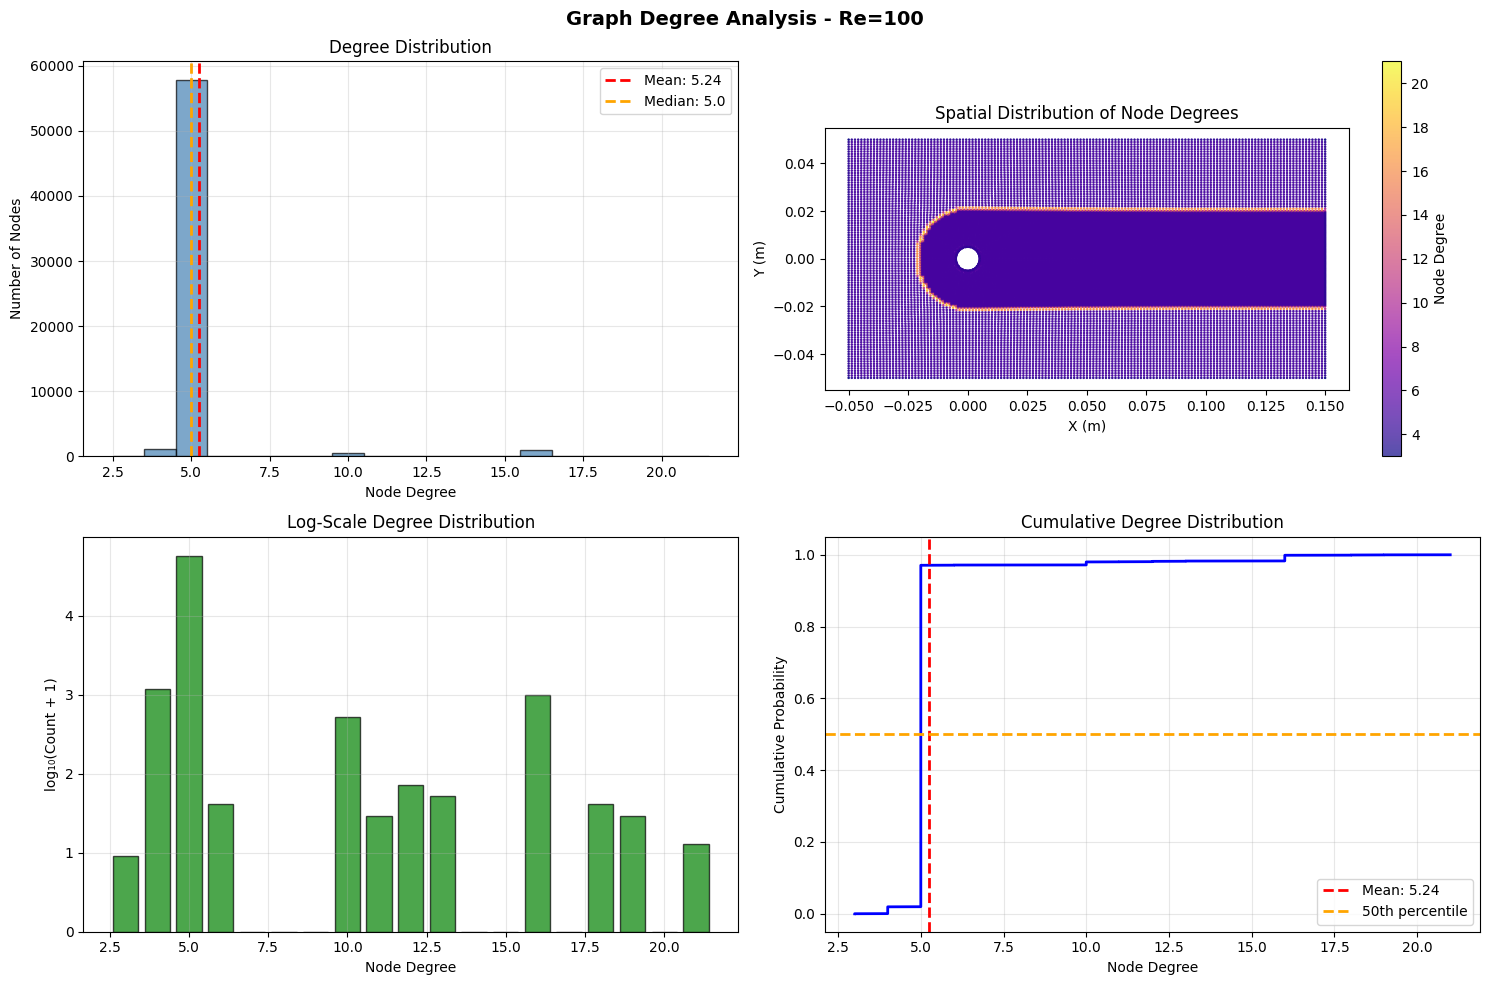


Degree Distribution Summary:
  Degree 3: 8 nodes (0.0%)
  Degree 4: 1,168 nodes (1.9%)
  Degree 5: 57,794 nodes (95.1%)
  Degree 6: 40 nodes (0.1%)
  Degree 10: 524 nodes (0.9%)
  Degree 11: 28 nodes (0.0%)
  Degree 12: 72 nodes (0.1%)
  Degree 13: 52 nodes (0.1%)
  Degree 16: 980 nodes (1.6%)
  Degree 18: 40 nodes (0.1%)
  ... and 2 more degree values


array([3, 4, 5, ..., 5, 5, 4])

In [25]:
plot_degree_histogram(full_dataset)

🎨 Creating Kármán Vortex Street Visualizations...
✅ Saved static plots as 'karman_vortex_analysis_re100.png'


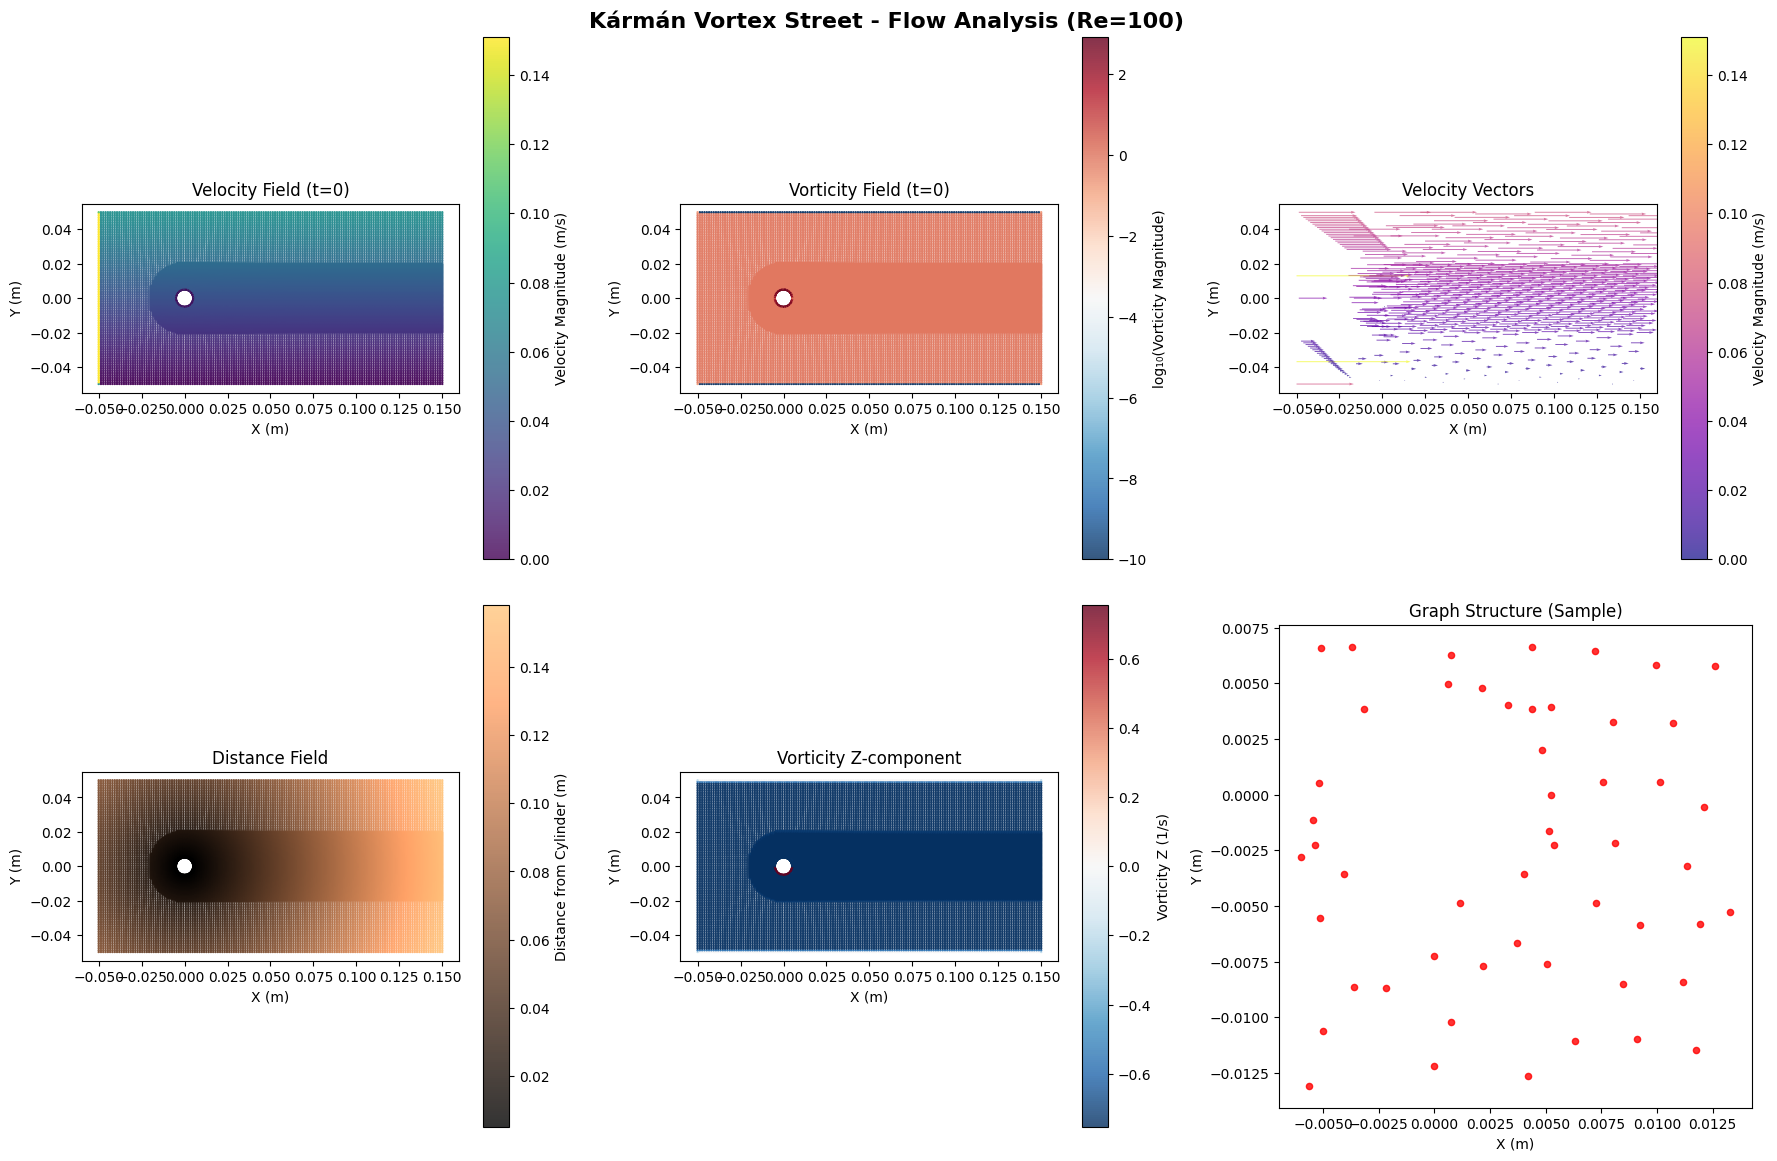

Creating temporal dataset with 5 timesteps...
Reynolds number: 100
✅ Complete! Created dataset with 5 timesteps
🎬 Creating temporal animation for velocity_magnitude (Re=100)...
✅ Saved animation as 'karman_vortex_velocity_magnitude_re100_animation.gif'


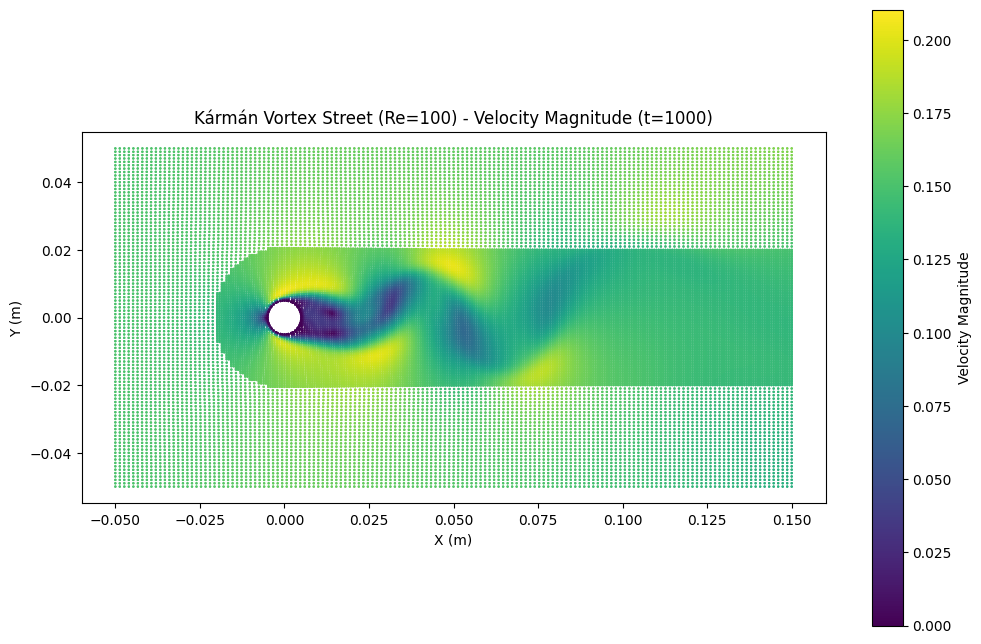

🎬 Creating temporal animation for vorticity_magnitude (Re=100)...
✅ Saved animation as 'karman_vortex_vorticity_magnitude_re100_animation.gif'


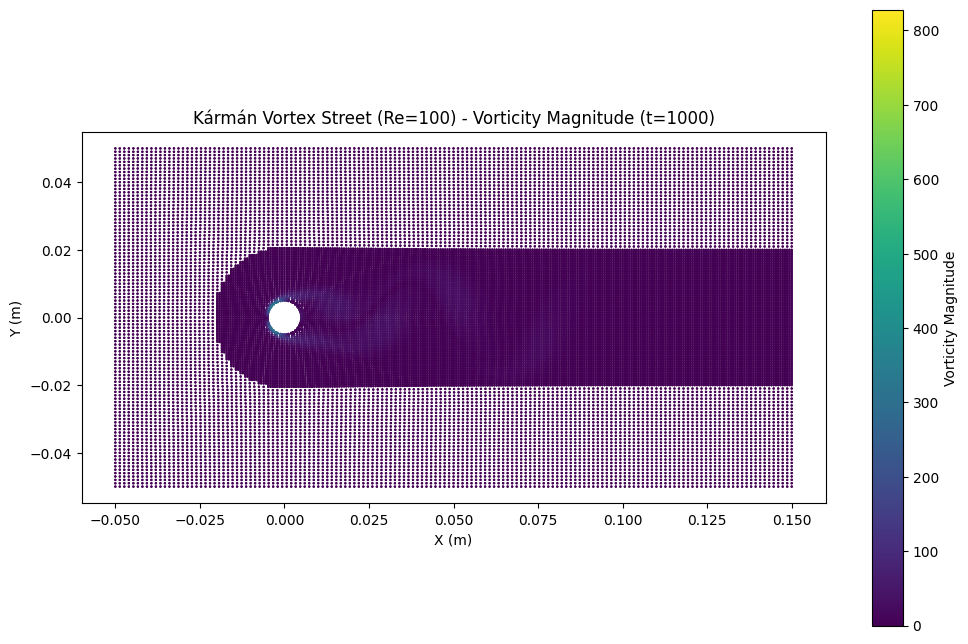

📊 Analyzing flow statistics across time (Re=100)...
✅ Saved flow statistics as 'karman_flow_statistics_re100.png'


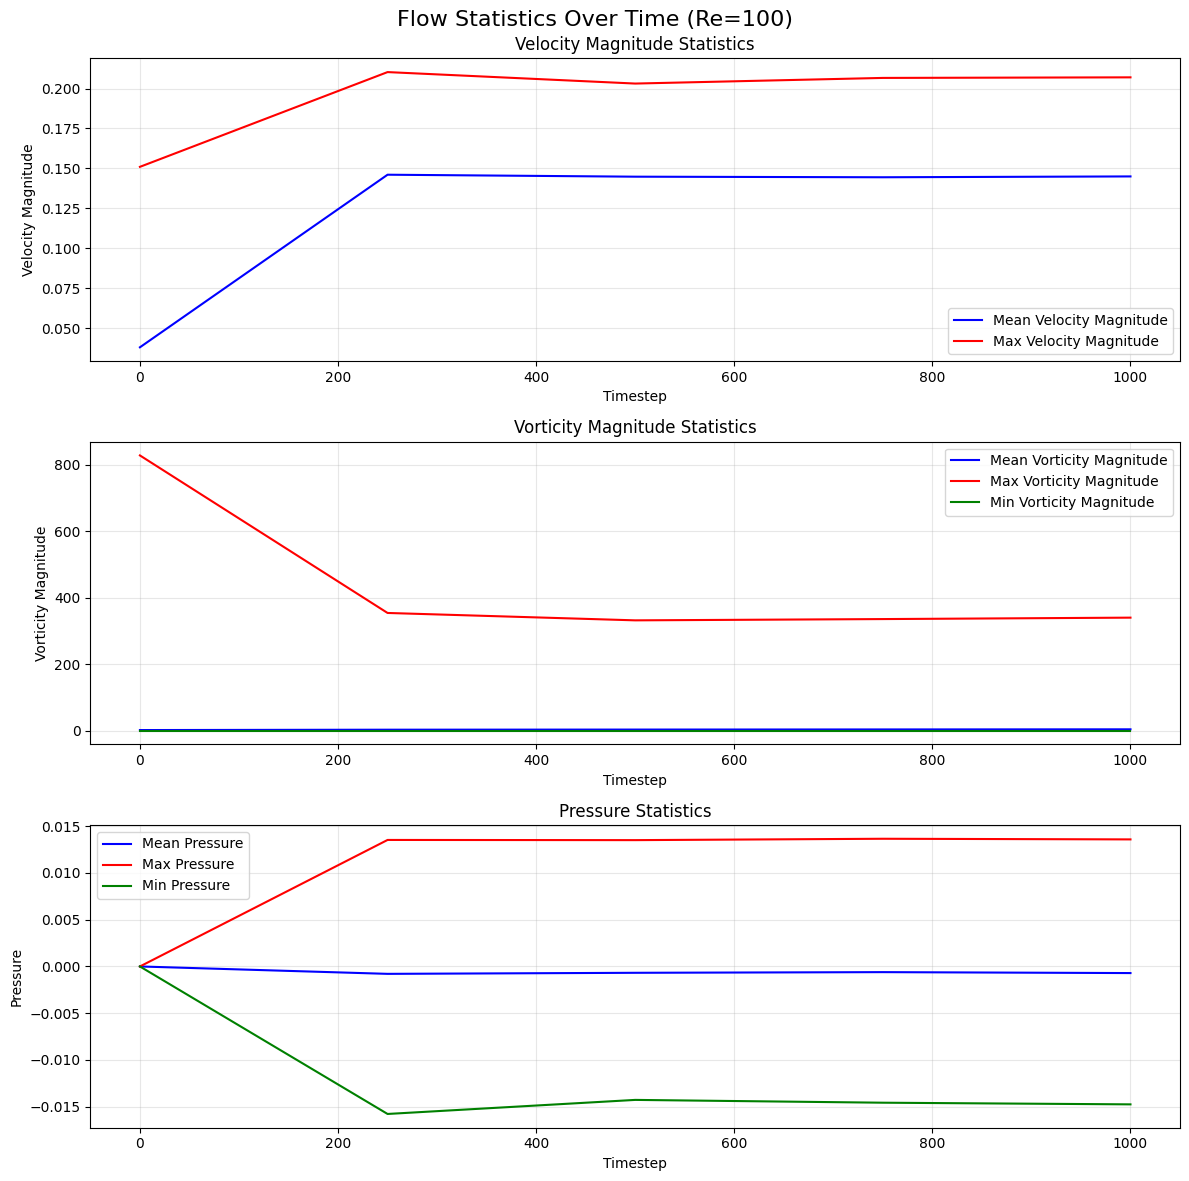

In [28]:
# Convert single timestep for static plots
raw_data = re100_conv.to_pytorch_geometric(timestep=0)

# 1. Create comprehensive static plots
visualize_karman_data(raw_data)

# For temporal analysis, create a dataset with multiple timesteps
temporal_dataset = re100_conv.create_temporal_dataset(timesteps=[0, 250, 500, 750, 1000])

# 2. Create animation showing temporal evolution
create_temporal_animation(temporal_dataset, feature='velocity_magnitude')
create_temporal_animation(temporal_dataset, feature='vorticity_magnitude')

# 3. Analyze statistics over time
analyze_flow_statistics(temporal_dataset)

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.patches import Circle

def create_full_simulation_gif(dataset, feature='velocity_magnitude', 
                             skip_frames=1, figsize=(12, 8), dpi=100,
                             fps=10, filename=None, reynolds_number=None,
                             show_mesh=False, mesh_alpha=0.1,
                             dynamic_colormap=False, percentile_range=(2, 98)):
    """
    Create GIF animation from full temporal dataset - generalized for any Reynolds number
    
    Parameters:
    -----------
    dataset : list of PyG Data objects
    feature : str, feature to visualize
    skip_frames : int, use every nth frame (1 = all frames, 2 = every other frame)
    fps : int, frames per second in final GIF
    filename : str, optional, if None will auto-generate based on Reynolds number and feature
    reynolds_number : int, optional, if None will try to auto-detect from data
    show_mesh : bool, whether to show mesh edges
    mesh_alpha : float, transparency of mesh edges (0-1)
    dynamic_colormap : bool, if True, adjust colormap per frame; if False, use global range
    percentile_range : tuple, percentile range for colormap (e.g., (5, 95) ignores extreme outliers)
    """
    
    # Auto-detect Reynolds number if not provided
    if reynolds_number is None:
        reynolds_number = getattr(dataset[0], 'reynolds_number', 'Unknown')
    
    # Auto-generate filename if not provided
    if filename is None:
        colormap_suffix = "_dynamic" if dynamic_colormap else ""
        filename = f'karman_{feature}_re{reynolds_number}{colormap_suffix}.gif'
    
    # Check if feature exists
    if feature not in dataset[0].feature_names:
        print(f"❌ Feature '{feature}' not found in dataset.")
        print(f"Available features: {dataset[0].feature_names}")
        return None
    
    print(f"Creating GIF animation with {len(dataset[::skip_frames])} frames...")
    print(f"Reynolds number: {reynolds_number}")
    print(f"Feature: {feature}")
    print(f"Skip frames: {skip_frames} (using every {skip_frames} timestep)")
    print(f"Dynamic colormap: {dynamic_colormap}")
    if show_mesh:
        print(f"Mesh visualization: ON (alpha={mesh_alpha})")
    
    # Get feature index
    feature_idx = dataset[0].feature_names.index(feature)
    
    # Get positions (same for all timesteps)
    pos_2d = dataset[0].pos[:, :2].numpy()
    
    # Handle edge index if available
    edge_index = None
    if hasattr(dataset[0], 'edge_index'):
        edge_index = dataset[0].edge_index.numpy()
    
    # Get colormap range
    if dynamic_colormap:
        print("Using dynamic colormap (per-frame scaling)")
        vmin, vmax = None, None  # Will be set per frame
    else:
        print("Computing global feature range...")
        all_values = []
        for i, data in enumerate(dataset[::skip_frames]):
            if i % 50 == 0:
                print(f"  Processing frame {i}/{len(dataset[::skip_frames])}")
            values = data.x[:, feature_idx].numpy()
            # Use percentiles to avoid extreme outliers
            vmin_frame = np.percentile(values, percentile_range[0])
            vmax_frame = np.percentile(values, percentile_range[1])
            all_values.extend([vmin_frame, vmax_frame])
        
        vmin, vmax = np.min(all_values), np.max(all_values)
        print(f"Global feature range: {vmin:.4f} to {vmax:.4f}")
    
    # Setup figure
    fig, ax = plt.subplots(figsize=figsize)
    fig.patch.set_facecolor('white')
    
    # Draw mesh edges if requested
    if show_mesh and edge_index is not None:
        print("Drawing mesh edges...")
        n_edges_to_show = min(50000, edge_index.shape[1])
        edge_sample = np.random.choice(edge_index.shape[1], n_edges_to_show, replace=False)
        
        for i in edge_sample:
            edge = edge_index[:, i]
            ax.plot([pos_2d[edge[0], 0], pos_2d[edge[1], 0]], 
                   [pos_2d[edge[0], 1], pos_2d[edge[1], 1]], 
                   'k-', alpha=mesh_alpha, linewidth=0.1)
    elif show_mesh and edge_index is None:
        print("⚠️ Mesh visualization requested but no edge information available")
    
    # Initial plot
    initial_values = dataset[0].x[:, feature_idx].numpy()
    if dynamic_colormap:
        frame_vmin = np.percentile(initial_values, percentile_range[0])
        frame_vmax = np.percentile(initial_values, percentile_range[1])
    else:
        frame_vmin, frame_vmax = vmin, vmax
        
    scatter = ax.scatter(pos_2d[:, 0], pos_2d[:, 1], 
                        c=initial_values,
                        cmap='viridis', s=0.5 if show_mesh else 0.3, 
                        vmin=frame_vmin, vmax=frame_vmax, alpha=0.9)
    
    # Styling
    ax.set_xlabel('X (m)', color='black', fontsize=12)
    ax.set_ylabel('Y (m)', color='black', fontsize=12)
    ax.set_aspect('equal')
    ax.set_facecolor('white')
    ax.tick_params(colors='black')
    
    # Colorbar
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label(feature.replace('_', ' ').title(), color='black', fontsize=12)
    cbar.ax.tick_params(colors='black')
    
    # Title
    mesh_text = " (with mesh)" if show_mesh else ""
    colormap_text = " (dynamic)" if dynamic_colormap else ""
    title = ax.set_title(f'Kármán Vortex Street - {feature.replace("_", " ").title()}{mesh_text}{colormap_text}\n' + 
                        f'Re={reynolds_number}, t={dataset[0].timestep}', 
                        color='black', fontsize=14, pad=20)
    
    # Animation function
    def animate(frame):
        data_idx = frame * skip_frames
        if data_idx >= len(dataset):
            data_idx = len(dataset) - 1
            
        data = dataset[data_idx]
        values = data.x[:, feature_idx].numpy()
        
        if dynamic_colormap:
            # Update colormap range for this frame
            frame_vmin = np.percentile(values, percentile_range[0])
            frame_vmax = np.percentile(values, percentile_range[1])
            scatter.set_clim(vmin=frame_vmin, vmax=frame_vmax)
        
        scatter.set_array(values)
        title.set_text(f'Kármán Vortex Street - {feature.replace("_", " ").title()}{mesh_text}{colormap_text}\n' + 
                      f'Re={reynolds_number}, t={data.timestep}')
        return scatter, title
    
    # Create animation
    print("Creating animation...")
    n_frames = len(dataset[::skip_frames])
    anim = animation.FuncAnimation(fig, animate, frames=n_frames, 
                                 interval=1000//fps, blit=False, repeat=True)
    
    # Save as GIF
    print(f"Saving GIF: {filename}")
    print("This may take several minutes...")
    
    writer = animation.PillowWriter(fps=fps, metadata=dict(artist='CFD-to-GNN'), bitrate=1800)
    anim.save(filename, writer=writer, dpi=dpi, savefig_kwargs={'facecolor': 'white'})
    
    print(f"✅ GIF saved successfully: {filename}")
    print(f"   Frames: {n_frames}")
    print(f"   Duration: ~{n_frames/fps:.1f} seconds")
    
    plt.show()
    return anim

def create_multi_feature_gif(dataset, features=['velocity_magnitude', 'vorticity_magnitude'], 
                           skip_frames=2, figsize=(16, 8), fps=8, filename=None, 
                           reynolds_number=None):
    """Create side-by-side comparison GIF - generalized version"""
    
    # Auto-detect Reynolds number if not provided
    if reynolds_number is None:
        reynolds_number = getattr(dataset[0], 'reynolds_number', 'Unknown')
    
    # Auto-generate filename if not provided
    if filename is None:
        filename = f'karman_multi_feature_{len(features)}x_re{reynolds_number}.gif'
    
    # Check if all features exist
    available_features = dataset[0].feature_names
    missing_features = [f for f in features if f not in available_features]
    if missing_features:
        print(f"❌ Missing features: {missing_features}")
        print(f"Available features: {available_features}")
        return None
    
    print(f"Creating multi-feature GIF with {len(features)} features...")
    print(f"Reynolds number: {reynolds_number}")
    print(f"Features: {features}")
    
    # Setup
    pos_2d = dataset[0].pos[:, :2].numpy()
    
    # Get feature indices and ranges
    feature_data = {}
    for feature in features:
        idx = dataset[0].feature_names.index(feature)
        
        # Get global range
        all_vals = []
        for data in dataset[::skip_frames]:
            all_vals.extend(data.x[:, idx].numpy())
        
        feature_data[feature] = {
            'idx': idx,
            'vmin': np.min(all_vals),
            'vmax': np.max(all_vals)
        }
    
    # Create figure
    fig, axes = plt.subplots(1, len(features), figsize=figsize)
    if len(features) == 1:
        axes = [axes]
    
    fig.patch.set_facecolor('white')
    
    # Initialize plots
    scatters = []
    titles = []
    
    for i, feature in enumerate(features):
        ax = axes[i]
        data_info = feature_data[feature]
        
        scatter = ax.scatter(pos_2d[:, 0], pos_2d[:, 1],
                           c=dataset[0].x[:, data_info['idx']].numpy(),
                           cmap='viridis', s=0.3, 
                           vmin=data_info['vmin'], vmax=data_info['vmax'])
        
        # Styling
        ax.set_xlabel('X (m)', color='black')
        ax.set_ylabel('Y (m)', color='black') 
        ax.set_aspect('equal')
        ax.set_facecolor('white')
        ax.tick_params(colors='black')
        
        # Colorbar
        cbar = plt.colorbar(scatter, ax=ax)
        cbar.set_label(feature.replace('_', ' ').title(), color='black')
        cbar.ax.tick_params(colors='black')
        
        # Title
        title = ax.set_title(f'{feature.replace("_", " ").title()}', 
                           color='black', fontsize=12)
        
        scatters.append(scatter)
        titles.append(title)
    
    # Main title
    main_title = fig.suptitle(f'Kármán Vortex Street - Re={reynolds_number}, t={dataset[0].timestep}',
                            color='black', fontsize=16)
    
    # Animation function
    def animate(frame):
        data_idx = frame * skip_frames
        if data_idx >= len(dataset):
            data_idx = len(dataset) - 1
            
        data = dataset[data_idx]
        
        for i, feature in enumerate(features):
            idx = feature_data[feature]['idx']
            values = data.x[:, idx].numpy()
            scatters[i].set_array(values)
        
        main_title.set_text(f'Kármán Vortex Street - Re={reynolds_number}, t={data.timestep}')
        
        return scatters + [main_title]
    
    # Create and save animation
    n_frames = len(dataset[::skip_frames])
    anim = animation.FuncAnimation(fig, animate, frames=n_frames,
                                 interval=1000//fps, blit=False, repeat=True)
    
    print(f"Saving multi-feature GIF: {filename}")
    
    writer = animation.PillowWriter(fps=fps, metadata=dict(artist='CFD-to-GNN'))
    anim.save(filename, writer=writer, dpi=100, savefig_kwargs={'facecolor': 'white'})
    
    print(f"✅ Multi-feature GIF saved: {filename}")
    plt.show()
    return anim

def create_reynolds_comparison_gif(datasets_dict, feature='velocity_magnitude', 
                                 skip_frames=2, figsize=(20, 8), fps=8,
                                 use_individual_colormaps=True, sync_domains=True):
    """
    Create side-by-side comparison of multiple Reynolds numbers
    
    Parameters:
    -----------
    datasets_dict : dict
        Dictionary with Reynolds numbers as keys and datasets as values
        e.g., {20: re20_dataset, 100: re100_dataset}
    feature : str
        Feature to visualize
    use_individual_colormaps : bool
        If True, each Reynolds gets its own colormap range (better dynamics)
        If False, uses global range across all (better for quantitative comparison)
    sync_domains : bool
        If True, synchronize axis limits across all subplots
    """
    
    print(f"Creating Reynolds number comparison GIF...")
    print(f"Reynolds numbers: {list(datasets_dict.keys())}")
    print(f"Feature: {feature}")
    print(f"Individual colormaps: {use_individual_colormaps}")
    print(f"Synchronized domains: {sync_domains}")
    
    # Check that all datasets have the feature
    for re_num, dataset in datasets_dict.items():
        if feature not in dataset[0].feature_names:
            print(f"❌ Feature '{feature}' not found in Re={re_num} dataset")
            return None
    
    # Get colormap ranges
    re_numbers = list(datasets_dict.keys())
    colormap_ranges = {}
    
    if use_individual_colormaps:
        print("Computing individual colormap ranges...")
        for re_num, dataset in datasets_dict.items():
            feature_idx = dataset[0].feature_names.index(feature)
            all_values = []
            for data in dataset[::skip_frames]:
                values = data.x[:, feature_idx].numpy()
                all_values.extend(values)
            
            vmin, vmax = np.min(all_values), np.max(all_values)
            colormap_ranges[re_num] = (vmin, vmax)
            print(f"  Re={re_num}: range=[{vmin:.4f}, {vmax:.4f}]")
    else:
        print("Computing global colormap range...")
        all_values = []
        for re_num, dataset in datasets_dict.items():
            feature_idx = dataset[0].feature_names.index(feature)
            for data in dataset[::skip_frames]:
                values = data.x[:, feature_idx].numpy()
                all_values.extend(values)
        
        global_vmin, global_vmax = np.min(all_values), np.max(all_values)
        print(f"Global range: [{global_vmin:.4f}, {global_vmax:.4f}]")
        for re_num in re_numbers:
            colormap_ranges[re_num] = (global_vmin, global_vmax)
    
    # Get domain bounds for synchronization
    if sync_domains:
        all_bounds = []
        for re_num, dataset in datasets_dict.items():
            pos_2d = dataset[0].pos[:, :2].numpy()
            bounds = [pos_2d[:, 0].min(), pos_2d[:, 0].max(), 
                     pos_2d[:, 1].min(), pos_2d[:, 1].max()]
            all_bounds.append(bounds)
        
        # Find global bounds
        global_xlim = [min(b[0] for b in all_bounds), max(b[1] for b in all_bounds)]
        global_ylim = [min(b[2] for b in all_bounds), max(b[3] for b in all_bounds)]
        print(f"Synchronized domain: x={global_xlim}, y={global_ylim}")
    
    # Create figure
    n_reynolds = len(datasets_dict)
    fig, axes = plt.subplots(1, n_reynolds, figsize=figsize)
    if n_reynolds == 1:
        axes = [axes]
    
    fig.patch.set_facecolor('white')
    
    # Initialize plots
    scatters = []
    cbars = []
    
    for i, re_num in enumerate(re_numbers):
        ax = axes[i]
        dataset = datasets_dict[re_num]
        feature_idx = dataset[0].feature_names.index(feature)
        pos_2d = dataset[0].pos[:, :2].numpy()
        
        vmin, vmax = colormap_ranges[re_num]
        
        scatter = ax.scatter(pos_2d[:, 0], pos_2d[:, 1],
                           c=dataset[0].x[:, feature_idx].numpy(),
                           cmap='viridis', s=0.3, vmin=vmin, vmax=vmax)
        
        # Styling
        ax.set_xlabel('X (m)', color='black')
        ax.set_ylabel('Y (m)', color='black')
        ax.set_aspect('equal')
        ax.set_facecolor('white')
        ax.tick_params(colors='black')
        ax.set_title(f'Re = {re_num}', color='black', fontsize=14)
        
        # Synchronize domains if requested
        if sync_domains:
            ax.set_xlim(global_xlim)
            ax.set_ylim(global_ylim)
        
        # Add individual colorbar for each subplot
        cbar = plt.colorbar(scatter, ax=ax)
        cbar.set_label(feature.replace('_', ' ').title(), color='black')
        cbar.ax.tick_params(colors='black')
        cbars.append(cbar)
        
        scatters.append(scatter)
    
    # Main title
    colormap_text = " (Individual Scales)" if use_individual_colormaps else " (Global Scale)"
    main_title = fig.suptitle(f'Reynolds Number Comparison - {feature.replace("_", " ").title()}{colormap_text}\n' + 
                            f't={datasets_dict[re_numbers[0]][0].timestep}',
                            color='black', fontsize=16)
    
    # Animation function
    def animate(frame):
        for i, re_num in enumerate(re_numbers):
            dataset = datasets_dict[re_num]
            data_idx = frame * skip_frames
            if data_idx >= len(dataset):
                data_idx = len(dataset) - 1
            
            data = dataset[data_idx]
            feature_idx = data.feature_names.index(feature)
            values = data.x[:, feature_idx].numpy()
            scatters[i].set_array(values)
            
            # Update colorbar limits if using individual colormaps
            if use_individual_colormaps:
                frame_vmin = np.percentile(values, 2)
                frame_vmax = np.percentile(values, 98)
                scatters[i].set_clim(vmin=frame_vmin, vmax=frame_vmax)
        
        # Update main title with timestep from first dataset
        first_dataset = datasets_dict[re_numbers[0]]
        data_idx = min(frame * skip_frames, len(first_dataset) - 1)
        main_title.set_text(f'Reynolds Number Comparison - {feature.replace("_", " ").title()}{colormap_text}\n' + 
                           f't={first_dataset[data_idx].timestep}')
        
        return scatters + [main_title]
    
    # Get minimum number of frames across all datasets
    min_frames = min(len(dataset[::skip_frames]) for dataset in datasets_dict.values())
    
    # Create and save animation
    anim = animation.FuncAnimation(fig, animate, frames=min_frames,
                                 interval=1000//fps, blit=False, repeat=True)
    
    colormap_suffix = "_individual" if use_individual_colormaps else "_global"
    filename = f'reynolds_comparison_{feature}_{"_".join(map(str, re_numbers))}{colormap_suffix}.gif'
    print(f"Saving Reynolds comparison GIF: {filename}")
    
    writer = animation.PillowWriter(fps=fps, metadata=dict(artist='CFD-to-GNN'))
    anim.save(filename, writer=writer, dpi=100, savefig_kwargs={'facecolor': 'white'})
    
    print(f"✅ Reynolds comparison GIF saved: {filename}")
    plt.show()
    return anim

# Usage examples
if __name__ == "__main__":
    print("Generalized GIF Animation Creator for Kármán Vortex Street")
    print("\nUsage:")
    print("1. Single Reynolds number:")
    print("   anim = create_full_simulation_gif(re20_dataset, 'velocity_magnitude')")
    print("   # Auto-generates filename: karman_velocity_magnitude_re20.gif")
    print("")
    print("2. Multi-feature comparison:")
    print("   anim = create_multi_feature_gif(re100_dataset, ['velocity_magnitude', 'vorticity_magnitude'])")
    print("   # Auto-generates filename: karman_multi_feature_2x_re100.gif")
    print("")
    print("3. Reynolds number comparison:")
    print("   anim = create_reynolds_comparison_gif({20: re20_dataset, 100: re100_dataset}, 'vorticity_magnitude')")
    print("   # Compares different Reynolds numbers side-by-side")

Generalized GIF Animation Creator for Kármán Vortex Street

Usage:
1. Single Reynolds number:
   anim = create_full_simulation_gif(re20_dataset, 'velocity_magnitude')
   # Auto-generates filename: karman_velocity_magnitude_re20.gif

2. Multi-feature comparison:
   anim = create_multi_feature_gif(re100_dataset, ['velocity_magnitude', 'vorticity_magnitude'])
   # Auto-generates filename: karman_multi_feature_2x_re100.gif

3. Reynolds number comparison:
   anim = create_reynolds_comparison_gif({20: re20_dataset, 100: re100_dataset}, 'vorticity_magnitude')
   # Compares different Reynolds numbers side-by-side


Creating Reynolds number comparison GIF...
Reynolds numbers: [20, 100]
Feature: vorticity_magnitude
Individual colormaps: True
Synchronized domains: True
Computing individual colormap ranges...
  Re=20: range=[0.0000, 165.6447]
  Re=100: range=[0.0000, 828.2237]
Synchronized domain: x=[-0.05, 0.15], y=[-0.05, 0.05]
Saving Reynolds comparison GIF: reynolds_comparison_vorticity_magnitude_20_100_individual.gif
✅ Reynolds comparison GIF saved: reynolds_comparison_vorticity_magnitude_20_100_individual.gif


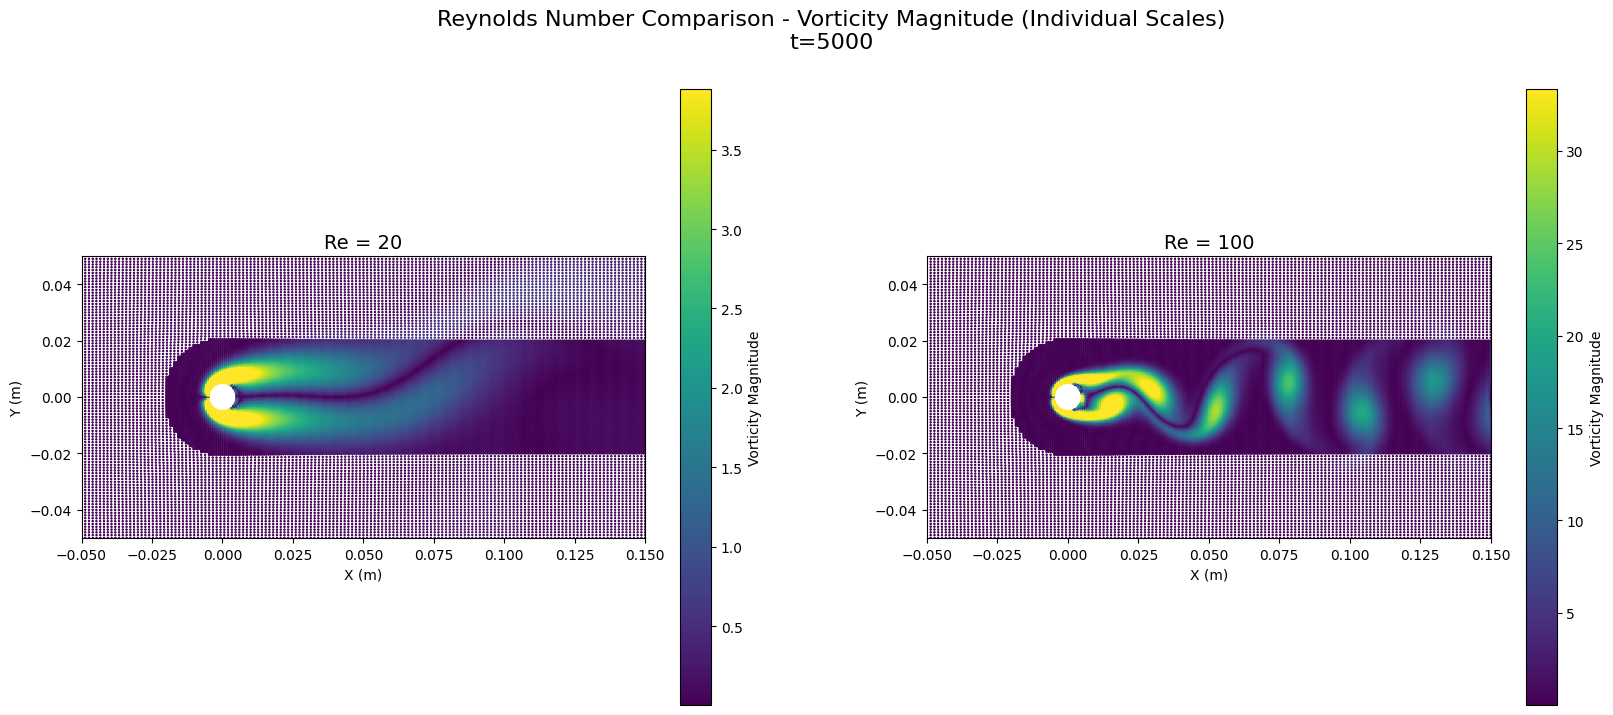

In [34]:
anim = create_reynolds_comparison_gif({20: re20_dataset, 100: full_dataset}, 'vorticity_magnitude')

In [6]:
import torch
import numpy as np
from pathlib import Path
import pickle
from torch_geometric.data import Data

class KarmanPyGDatasetSaver:
    """
    Save Kármán vortex street simulations as PyTorch Geometric datasets
    Similar to the shock tube pipeline but for fluid dynamics simulations
    """
    
    def __init__(self, converter):
        """
        Initialize with a GeneralizedVTKConverter instance
        
        Parameters:
        -----------
        converter : GeneralizedVTKConverter
            Initialized converter for the simulation
        """
        self.converter = converter
        self.reynolds_number = getattr(converter, 'reynolds_number', 'Unknown')
        
    def create_temporal_pyg_dataset(self, timesteps=None, skip_frames=1, 
                                  save_path=None, include_targets=True):
        """
        Create a PyG dataset from temporal sequence of Kármán vortex street data
        
        Parameters:
        -----------
        timesteps : list, optional
            List of timesteps to include. If None, uses all available
        skip_frames : int
            Use every nth timestep (1 = all timesteps)
        save_path : str, optional
            Path to save the dataset. Auto-generates if None
        include_targets : bool
            If True, creates (current_timestep -> next_timestep) pairs for prediction
            If False, just saves individual timesteps
        
        Returns:
        --------
        list : List of PyG Data objects
        """
        
        if timesteps is None:
            timesteps = self.converter.timesteps[::skip_frames]
        else:
            timesteps = timesteps[::skip_frames]
        
        if save_path is None:
            dataset_type = "prediction" if include_targets else "temporal"
            save_path = f"karman_vortex_re{self.reynolds_number}_{dataset_type}_dataset.pt"
        
        print(f"Creating PyG dataset for Kármán vortex street (Re={self.reynolds_number})")
        print(f"Timesteps: {len(timesteps)}")
        print(f"Dataset type: {'Prediction pairs' if include_targets else 'Individual timesteps'}")
        
        pyg_dataset = []
        
        if include_targets and len(timesteps) < 2:
            print("❌ Need at least 2 timesteps for prediction dataset")
            return None
        
        # Determine range for processing
        processing_range = len(timesteps) - 1 if include_targets else len(timesteps)
        
        for i in range(processing_range):
            current_timestep = timesteps[i]
            
            if i % 10 == 0:  # Progress update
                print(f"  Processing timestep {current_timestep} ({i+1}/{processing_range})")
            
            # Load current timestep
            current_data = self.converter.to_pytorch_geometric(current_timestep)
            
            if include_targets:
                # Load next timestep as target
                next_timestep = timesteps[i + 1]
                next_data = self.converter.to_pytorch_geometric(next_timestep)
                
                # Create PyG Data object with current as input and next as target
                data_object = Data(
                    x=current_data.x,                    # Current timestep features
                    pos=current_data.pos,                # Node positions (constant)
                    edge_index=current_data.edge_index,  # Graph connectivity
                    y=next_data.x,                       # Next timestep as target
                    
                    # Metadata
                    timestep=current_timestep,
                    next_timestep=next_timestep,
                    reynolds_number=self.reynolds_number,
                    feature_names=current_data.feature_names
                )
            else:
                # Just save individual timesteps
                data_object = Data(
                    x=current_data.x,
                    pos=current_data.pos,
                    edge_index=current_data.edge_index,
                    
                    # Metadata
                    timestep=current_timestep,
                    reynolds_number=self.reynolds_number,
                    feature_names=current_data.feature_names
                )
            
            pyg_dataset.append(data_object)
        
        print(f"✅ PyG dataset creation complete: {len(pyg_dataset)} samples")
        
        # Save dataset
        torch.save(pyg_dataset, save_path)
        print(f"💾 Dataset saved to '{save_path}'")
        
        # Save metadata separately
        metadata = {
            'reynolds_number': self.reynolds_number,
            'n_samples': len(pyg_dataset),
            'n_nodes': pyg_dataset[0].num_nodes,
            'n_edges': pyg_dataset[0].num_edges,
            'n_features': pyg_dataset[0].x.shape[1],
            'feature_names': pyg_dataset[0].feature_names,
            'timesteps': timesteps[:processing_range],
            'dataset_type': 'prediction' if include_targets else 'temporal',
            'domain_bounds': {
                'x_min': float(pyg_dataset[0].pos[:, 0].min()),
                'x_max': float(pyg_dataset[0].pos[:, 0].max()),
                'y_min': float(pyg_dataset[0].pos[:, 1].min()),
                'y_max': float(pyg_dataset[0].pos[:, 1].max())
            }
        }
        
        metadata_path = save_path.replace('.pt', '_metadata.pkl')
        with open(metadata_path, 'wb') as f:
            pickle.dump(metadata, f)
        print(f"📋 Metadata saved to '{metadata_path}'")
        
        return pyg_dataset
    
    def create_multi_reynolds_dataset(self, reynolds_converters, timesteps=None, 
                                    skip_frames=1, save_path=None):
        """
        Create a combined dataset from multiple Reynolds number simulations
        
        Parameters:
        -----------
        reynolds_converters : dict
            Dictionary mapping Reynolds numbers to converter instances
            e.g., {20: re20_converter, 100: re100_converter}
        """
        
        if save_path is None:
            re_numbers = "_".join(map(str, reynolds_converters.keys()))
            save_path = f"karman_vortex_multi_re_{re_numbers}_dataset.pt"
        
        print(f"Creating multi-Reynolds PyG dataset")
        print(f"Reynolds numbers: {list(reynolds_converters.keys())}")
        
        combined_dataset = []
        
        for re_num, converter in reynolds_converters.items():
            print(f"\nProcessing Re={re_num}...")
            
            # Create saver for this Reynolds number
            saver = KarmanPyGDatasetSaver(converter)
            
            # Get dataset for this Reynolds number
            re_dataset = saver.create_temporal_pyg_dataset(
                timesteps=timesteps, 
                skip_frames=skip_frames,
                save_path=None,  # Don't save individual datasets
                include_targets=True
            )
            
            combined_dataset.extend(re_dataset)
        
        print(f"\n✅ Combined dataset created: {len(combined_dataset)} samples")
        
        # Save combined dataset
        torch.save(combined_dataset, save_path)
        print(f"💾 Combined dataset saved to '{save_path}'")
        
        # Create combined metadata
        metadata = {
            'reynolds_numbers': list(reynolds_converters.keys()),
            'n_total_samples': len(combined_dataset),
            'samples_per_reynolds': {re: sum(1 for d in combined_dataset 
                                           if d.reynolds_number == re) 
                                   for re in reynolds_converters.keys()},
            'n_nodes': combined_dataset[0].num_nodes,
            'n_edges': combined_dataset[0].num_edges, 
            'n_features': combined_dataset[0].x.shape[1],
            'feature_names': combined_dataset[0].feature_names,
            'dataset_type': 'multi_reynolds_prediction'
        }
        
        metadata_path = save_path.replace('.pt', '_metadata.pkl')
        with open(metadata_path, 'wb') as f:
            pickle.dump(metadata, f)
        print(f"📋 Combined metadata saved to '{metadata_path}'")
        
        return combined_dataset
    
    def inspect_dataset(self, dataset_path):
        """Load and inspect a saved PyG dataset"""
        
        print(f"🔍 Inspecting PyG dataset: {dataset_path}")
        
        # Load dataset
        dataset = torch.load(dataset_path)
        print(f"Dataset loaded: {len(dataset)} samples")
        
        # Load metadata if available
        metadata_path = dataset_path.replace('.pt', '_metadata.pkl')
        if Path(metadata_path).exists():
            with open(metadata_path, 'rb') as f:
                metadata = pickle.load(f)
            print(f"Metadata found:")
            for key, value in metadata.items():
                print(f"  {key}: {value}")
        
        # Inspect first sample
        print(f"\nFirst sample inspection:")
        first_sample = dataset[0]
        print(first_sample)
        print(f"  Nodes: {first_sample.num_nodes:,}")
        print(f"  Edges: {first_sample.num_edges:,}")
        print(f"  Features: {first_sample.x.shape}")
        
        if hasattr(first_sample, 'y') and first_sample.y is not None:
            print(f"  Targets: {first_sample.y.shape}")
            print("  → This is a prediction dataset")
        else:
            print("  → This is a temporal sequence dataset")
        
        if hasattr(first_sample, 'feature_names'):
            print(f"  Feature names: {first_sample.feature_names}")
        
        return dataset, metadata if Path(metadata_path).exists() else None

# Convenience functions
def save_karman_dataset(data_dir, save_path=None, skip_startup_frames=50):
    """
    Convenience function to save a Kármán dataset from a simulation directory
    
    Parameters:
    -----------
    data_dir : str
        Path to simulation directory (e.g., Reynolds_20, Reynolds_100)
    save_path : str, optional
        Custom save path
    skip_startup_frames : int
        Skip first N timesteps to avoid startup transients
    """
    from pathlib import Path
    
    # Import the generalized converter
    try:
        from your_converter_module import GeneralizedVTKConverter
    except ImportError:
        print("❌ GeneralizedVTKConverter not found. Make sure it's imported.")
        return None
    
    # Initialize converter
    converter = GeneralizedVTKConverter(data_dir)
    
    # Skip startup transients
    steady_timesteps = converter.timesteps[skip_startup_frames:]
    
    # Create saver and save dataset
    saver = KarmanPyGDatasetSaver(converter)
    dataset = saver.create_temporal_pyg_dataset(
        timesteps=steady_timesteps,
        save_path=save_path,
        include_targets=True
    )
    
    return dataset

# Usage examples
if __name__ == "__main__":
    print("Kármán Vortex Street PyG Dataset Saver")
    print("\nUsage:")
    print("1. Single Reynolds number:")
    print("   saver = KarmanPyGDatasetSaver(converter)")
    print("   dataset = saver.create_temporal_pyg_dataset()")
    print("")
    print("2. Multi-Reynolds dataset:")
    print("   saver.create_multi_reynolds_dataset({20: re20_conv, 100: re100_conv})")
    print("")
    print("3. Inspect saved dataset:")
    print("   saver.inspect_dataset('karman_vortex_re20_prediction_dataset.pt')")

Kármán Vortex Street PyG Dataset Saver

Usage:
1. Single Reynolds number:
   saver = KarmanPyGDatasetSaver(converter)
   dataset = saver.create_temporal_pyg_dataset()

2. Multi-Reynolds dataset:
   saver.create_multi_reynolds_dataset({20: re20_conv, 100: re100_conv})

3. Inspect saved dataset:
   saver.inspect_dataset('karman_vortex_re20_prediction_dataset.pt')


In [8]:
# Create saver
re20_saver = KarmanPyGDatasetSaver(re20_converter)

# Save prediction dataset (current -> next timestep pairs)
re20_dataset = re20_saver.create_temporal_pyg_dataset(
    timesteps=re20_converter.timesteps,  # Skip startup transient
    save_path="/standard/sds_baek_energetic/G-PARC/Karman_Vortex_Processed/karman_re20_prediction.pt",
    include_targets=True
)

Creating PyG dataset for Kármán vortex street (Re=20)
Timesteps: 201
Dataset type: Prediction pairs
  Processing timestep 0 (1/200)
  Processing timestep 250 (11/200)
  Processing timestep 500 (21/200)
  Processing timestep 750 (31/200)
  Processing timestep 1000 (41/200)
  Processing timestep 1250 (51/200)
  Processing timestep 1500 (61/200)
  Processing timestep 1750 (71/200)
  Processing timestep 2000 (81/200)
  Processing timestep 2250 (91/200)
  Processing timestep 2500 (101/200)
  Processing timestep 2750 (111/200)
  Processing timestep 3000 (121/200)
  Processing timestep 3250 (131/200)
  Processing timestep 3500 (141/200)
  Processing timestep 3750 (151/200)
  Processing timestep 4000 (161/200)
  Processing timestep 4250 (171/200)
  Processing timestep 4500 (181/200)
  Processing timestep 4750 (191/200)
✅ PyG dataset creation complete: 200 samples
💾 Dataset saved to '/standard/sds_baek_energetic/G-PARC/Karman_Vortex_Processed/karman_re20_prediction.pt'
📋 Metadata saved to '/sta

In [9]:
re100_saver = KarmanPyGDatasetSaver(re100_converter)
re100_dataset = re100_saver.create_temporal_pyg_dataset(
    timesteps=re100_converter.timesteps,
    save_path="/standard/sds_baek_energetic/G-PARC/Karman_Vortex_Processed/karman_re20_prediction.pt",
    include_targets=True
)

Creating PyG dataset for Kármán vortex street (Re=100)
Timesteps: 201
Dataset type: Prediction pairs
  Processing timestep 0 (1/200)


KeyboardInterrupt: 

In [15]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.utils import degree, to_networkx
from pathlib import Path
import pickle
import collections

class KarmanPyGAnalyzer:
    """
    Load and analyze saved Kármán vortex street PyG datasets
    """
    
    def __init__(self, dataset_path):
        """
        Initialize with path to saved PyG dataset
        
        Parameters:
        -----------
        dataset_path : str or Path
            Path to the saved .pt dataset file
        """
        self.dataset_path = Path(dataset_path)
        self.dataset = None
        self.metadata = None
        
    def load_dataset(self):
        """Load the PyG dataset and metadata"""
        if not self.dataset_path.exists():
            print(f"❌ Error: Dataset file not found at '{self.dataset_path}'")
            return False
            
        print(f"Loading Kármán vortex dataset from '{self.dataset_path}'...")
        self.dataset = torch.load(self.dataset_path, weights_only=False)
        print(f"Dataset loaded successfully: {len(self.dataset)} samples")
        
        # Load metadata if available
        metadata_path = self.dataset_path.parent / (self.dataset_path.stem + "_metadata.pkl")
        if metadata_path.exists():
            with open(metadata_path, 'rb') as f:
                self.metadata = pickle.load(f)
            print("Metadata loaded successfully")
        else:
            print("No metadata file found")
            
        return True
    
    def analyze_dataset_structure(self):
        """Analyze the overall dataset properties"""
        if self.dataset is None:
            if not self.load_dataset():
                return
                
        print("\n=== Kármán Vortex Street Dataset Analysis ===")
        print(f"Dataset file: {self.dataset_path.name}")
        print(f"Total samples: {len(self.dataset)}")
        
        # Analyze first sample
        first_sample = self.dataset[0]
        print(f"\n--- Graph Structure ---")
        print(f"Nodes per graph: {first_sample.num_nodes:,}")
        print(f"Edges per graph: {first_sample.num_edges:,}")
        print(f"Features per node: {first_sample.x.shape[1]}")
        
        if hasattr(first_sample, 'pos'):
            print(f"Spatial dimensions: {first_sample.pos.shape[1]}")
        
        print(f"Is directed: {first_sample.is_directed()}")
        print(f"Has isolated nodes: {first_sample.has_isolated_nodes()}")
        print(f"Has self-loops: {first_sample.has_self_loops()}")
        
        # Dataset type
        if hasattr(first_sample, 'y') and first_sample.y is not None:
            print(f"Target shape: {first_sample.y.shape}")
            print("Dataset type: Prediction (current -> next timestep)")
        else:
            print("Dataset type: Temporal sequence")
            
        # Metadata analysis
        if self.metadata:
            print(f"\n--- Metadata ---")
            for key, value in self.metadata.items():
                if isinstance(value, (int, float, str)):
                    print(f"{key}: {value}")
                elif isinstance(value, list) and len(value) < 20:
                    print(f"{key}: {value}")
                elif isinstance(value, dict):
                    print(f"{key}: {list(value.keys())}")
                    
        # Feature analysis
        if hasattr(first_sample, 'feature_names'):
            print(f"\n--- Available Features ---")
            for i, name in enumerate(first_sample.feature_names):
                feature_data = first_sample.x[:, i]
                print(f"{i+1}. {name}: range=[{feature_data.min():.4f}, {feature_data.max():.4f}]")
    
    def analyze_graph_connectivity(self):
        """Analyze the graph connectivity structure"""
        if self.dataset is None:
            if not self.load_dataset():
                return
                
        data = self.dataset[0]
        
        print("\n--- Graph Connectivity Analysis ---")
        
        # Degree analysis
        degrees = degree(data.edge_index[0], num_nodes=data.num_nodes).numpy()
        degree_counts = collections.Counter(degrees)
        
        print("Node degree distribution:")
        for deg, count in sorted(degree_counts.items()):
            percentage = (count / data.num_nodes) * 100
            print(f"  Degree {int(deg)}: {count:,} nodes ({percentage:.1f}%)")
            
        # Statistical analysis
        print(f"\nDegree statistics:")
        print(f"  Mean degree: {np.mean(degrees):.2f}")
        print(f"  Median degree: {np.median(degrees)}")
        print(f"  Standard deviation: {np.std(degrees):.2f}")
        print(f"  Min/Max degree: {np.min(degrees)}/{np.max(degrees)}")
        
        # Connectivity interpretation for fluid mesh
        if np.max(degrees) <= 20:  # Reasonable for CFD mesh
            print(f"\n--- Fluid Mesh Interpretation ---")
            most_common_degree = degree_counts.most_common(1)[0][0]
            
            if most_common_degree == 5:
                print("  Dominant degree 5: Likely hexahedral mesh interior nodes")
            elif most_common_degree == 4:
                print("  Dominant degree 4: Likely quadrilateral mesh")
            elif most_common_degree in [8, 9]:
                print("  Dominant degree 8-9: Likely k-NN graph connectivity")
            
            boundary_nodes = np.sum(degrees < most_common_degree)
            print(f"  Estimated boundary nodes: {boundary_nodes:,} ({boundary_nodes/data.num_nodes*100:.1f}%)")
    
    def visualize_sample_connectivity(self, sample_idx=0, region_size=0.02, max_nodes=500):
        """
        Visualize a sample region of the graph connectivity
        
        Parameters:
        -----------
        sample_idx : int
            Which sample to visualize
        region_size : float  
            Size of region to sample around center
        max_nodes : int
            Maximum nodes to show for performance
        """
        if self.dataset is None:
            if not self.load_dataset():
                return
                
        data = self.dataset[sample_idx]
        
        print(f"Visualizing connectivity sample from dataset item {sample_idx}...")
        
        if not hasattr(data, 'pos'):
            print("❌ No position information available for visualization")
            return
            
        # Get 2D positions
        pos_2d = data.pos[:, :2].numpy()
        
        # Find center region
        center_x, center_y = pos_2d.mean(axis=0)
        
        # Select nodes in region around center
        region_mask = ((np.abs(pos_2d[:, 0] - center_x) < region_size) & 
                      (np.abs(pos_2d[:, 1] - center_y) < region_size))
        region_nodes = np.where(region_mask)[0]
        
        # Limit number of nodes for performance
        if len(region_nodes) > max_nodes:
            region_nodes = np.random.choice(region_nodes, max_nodes, replace=False)
            
        print(f"Showing {len(region_nodes)} nodes in region")
        
        # Create figure
        plt.figure(figsize=(12, 10))
        
        # Plot nodes
        plt.scatter(pos_2d[region_nodes, 0], pos_2d[region_nodes, 1], 
                   c='red', s=20, alpha=0.7, zorder=2, label='Nodes')
        
        # Plot edges
        edge_index = data.edge_index.numpy()
        edges_drawn = 0
        
        for node in region_nodes:
            # Find edges connected to this node
            connected_edges = edge_index[:, edge_index[0] == node]
            for edge in connected_edges.T:
                if edge[1] in region_nodes:  # Only show edges within region
                    plt.plot([pos_2d[edge[0], 0], pos_2d[edge[1], 0]], 
                            [pos_2d[edge[0], 1], pos_2d[edge[1], 1]], 
                            'b-', alpha=0.5, linewidth=0.8)
                    edges_drawn += 1
                    
        print(f"Drew {edges_drawn} edges")
        
        plt.xlabel('X (m)')
        plt.ylabel('Y (m)')
        plt.title(f'Graph Connectivity Sample - Kármán Vortex Street\n'
                 f'Re={getattr(data, "reynolds_number", "Unknown")}, t={getattr(data, "timestep", "Unknown")}')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.axis('equal')
        plt.show()
    
    def visualize_feature_distribution(self, feature_name, sample_idx=0, timestep_range=None):
        """
        Visualize the spatial distribution of a specific feature
        
        Parameters:
        -----------
        feature_name : str
            Name of feature to visualize
        sample_idx : int
            Which sample to visualize (if single timestep)
        timestep_range : list, optional
            Range of timesteps to show in animation-like plot
        """
        if self.dataset is None:
            if not self.load_dataset():
                return
                
        data = self.dataset[sample_idx]
        
        # Check if feature exists
        if not hasattr(data, 'feature_names') or feature_name not in data.feature_names:
            available = getattr(data, 'feature_names', ['Unknown'])
            print(f"❌ Feature '{feature_name}' not found.")
            print(f"Available features: {available}")
            return
            
        if not hasattr(data, 'pos'):
            print("❌ No position information available for spatial visualization")
            return
            
        feature_idx = data.feature_names.index(feature_name)
        pos_2d = data.pos[:, :2].numpy()
        
        if timestep_range is None:
            # Single timestep visualization
            feature_values = data.x[:, feature_idx].numpy()
            
            plt.figure(figsize=(12, 8))
            scatter = plt.scatter(pos_2d[:, 0], pos_2d[:, 1], c=feature_values, 
                                cmap='viridis', s=0.5, alpha=0.8)
            plt.colorbar(scatter, label=feature_name.replace('_', ' ').title())
            plt.xlabel('X (m)')
            plt.ylabel('Y (m)')
            plt.title(f'{feature_name.replace("_", " ").title()} Distribution\n'
                     f'Re={getattr(data, "reynolds_number", "Unknown")}, t={getattr(data, "timestep", "Unknown")}')
            plt.axis('equal')
            plt.show()
            
        else:
            # Multi-timestep visualization
            n_timesteps = len(timestep_range)
            fig, axes = plt.subplots(1, min(n_timesteps, 4), figsize=(16, 4))
            if n_timesteps == 1:
                axes = [axes]
                
            for i, ts_idx in enumerate(timestep_range[:4]):
                if ts_idx < len(self.dataset):
                    ts_data = self.dataset[ts_idx]
                    ts_values = ts_data.x[:, feature_idx].numpy()
                    
                    ax = axes[i] if n_timesteps > 1 else axes[0]
                    scatter = ax.scatter(pos_2d[:, 0], pos_2d[:, 1], c=ts_values, 
                                       cmap='viridis', s=0.5, alpha=0.8)
                    ax.set_xlabel('X (m)')
                    ax.set_ylabel('Y (m)')
                    ax.set_title(f't={getattr(ts_data, "timestep", ts_idx)}')
                    ax.set_aspect('equal')
                    plt.colorbar(scatter, ax=ax)
                    
            plt.suptitle(f'{feature_name.replace("_", " ").title()} Evolution')
            plt.tight_layout()
            plt.show()
    
    def analyze_feature_ranges_over_time(self, timestep_indices=None, feature_names=None):
        """
        Analyze feature ranges across different timesteps
        
        Parameters:
        -----------
        timestep_indices : list, optional
            Which timestep samples to analyze. If None, samples evenly across dataset
        feature_names : list, optional
            Which features to analyze. If None, analyzes all features
        """
        if self.dataset is None:
            if not self.load_dataset():
                return
                
        # Default to sampling across the dataset
        if timestep_indices is None:
            n_samples = min(10, len(self.dataset))  # Sample up to 10 timesteps
            timestep_indices = np.linspace(0, len(self.dataset)-1, n_samples, dtype=int)
        
        # Get feature names
        first_sample = self.dataset[0]
        if feature_names is None:
            if hasattr(first_sample, 'feature_names'):
                feature_names = first_sample.feature_names
            else:
                feature_names = [f'feature_{i}' for i in range(first_sample.x.shape[1])]
        
        print(f"\n--- Feature Range Analysis Across Timesteps ---")
        print(f"Analyzing {len(timestep_indices)} timesteps: {timestep_indices}")
        print(f"Features: {feature_names}\n")
        
        # Collect statistics for each feature across timesteps
        feature_stats = {}
        
        for feature_name in feature_names:
            if hasattr(first_sample, 'feature_names') and feature_name in first_sample.feature_names:
                feature_idx = first_sample.feature_names.index(feature_name)
            else:
                continue
                
            feature_stats[feature_name] = {
                'timesteps': [],
                'mins': [],
                'maxs': [],
                'means': [],
                'stds': []
            }
            
            for ts_idx in timestep_indices:
                if ts_idx < len(self.dataset):
                    data = self.dataset[ts_idx]
                    feature_values = data.x[:, feature_idx].numpy()
                    
                    feature_stats[feature_name]['timesteps'].append(getattr(data, 'timestep', ts_idx))
                    feature_stats[feature_name]['mins'].append(feature_values.min())
                    feature_stats[feature_name]['maxs'].append(feature_values.max())
                    feature_stats[feature_name]['means'].append(feature_values.mean())
                    feature_stats[feature_name]['stds'].append(feature_values.std())
        
        # Print tabular results
        for feature_name, stats in feature_stats.items():
            print(f"=== {feature_name.upper()} ===")
            print(f"{'Timestep':<10} {'Min':<12} {'Max':<12} {'Mean':<12} {'Std':<12}")
            print("-" * 58)
            
            for i, timestep in enumerate(stats['timesteps']):
                print(f"{timestep:<10} {stats['mins'][i]:<12.6f} {stats['maxs'][i]:<12.6f} "
                      f"{stats['means'][i]:<12.6f} {stats['stds'][i]:<12.6f}")
            print()
        
        # Create visualization
        self._plot_feature_ranges_over_time(feature_stats)
        
        return feature_stats
    
    def _plot_feature_ranges_over_time(self, feature_stats):
        """Create plots showing feature evolution over time"""
        
        n_features = len(feature_stats)
        if n_features == 0:
            return
            
        # Limit to most interesting features for plotting
        plot_features = list(feature_stats.keys())[:6]  # Max 6 features
        
        fig, axes = plt.subplots(2, 3, figsize=(18, 10))
        axes = axes.flatten()
        
        for i, feature_name in enumerate(plot_features):
            if i >= 6:  # Max 6 subplots
                break
                
            ax = axes[i]
            stats = feature_stats[feature_name]
            timesteps = stats['timesteps']
            
            # Plot min/max range as filled area
            ax.fill_between(timesteps, stats['mins'], stats['maxs'], 
                           alpha=0.3, label='Min-Max Range')
            
            # Plot mean
            ax.plot(timesteps, stats['means'], 'b-', linewidth=2, label='Mean')
            
            # Plot mean ± std
            means = np.array(stats['means'])
            stds = np.array(stats['stds'])
            ax.plot(timesteps, means + stds, 'r--', alpha=0.7, label='Mean ± Std')
            ax.plot(timesteps, means - stds, 'r--', alpha=0.7)
            
            ax.set_xlabel('Timestep')
            ax.set_ylabel(feature_name.replace('_', ' ').title())
            ax.set_title(f'{feature_name.replace("_", " ").title()} Evolution')
            ax.legend()
            ax.grid(True, alpha=0.3)
        
        # Hide unused subplots
        for i in range(len(plot_features), 6):
            axes[i].set_visible(False)
            
        plt.suptitle('Feature Range Evolution Over Time')
        plt.tight_layout()
        plt.show()
    
    def analyze_single_timestep_features(self, timestep_idx=0):
        """
        Analyze feature ranges for a single timestep in detail
        
        Parameters:
        -----------
        timestep_idx : int
            Which timestep sample to analyze
        """
        if self.dataset is None:
            if not self.load_dataset():
                return
                
        if timestep_idx >= len(self.dataset):
            print(f"Error: Timestep index {timestep_idx} out of range (0-{len(self.dataset)-1})")
            return
            
        data = self.dataset[timestep_idx]
        
        print(f"\n--- Single Timestep Feature Analysis ---")
        print(f"Dataset sample: {timestep_idx}")
        print(f"Timestep: {getattr(data, 'timestep', 'Unknown')}")
        print(f"Reynolds number: {getattr(data, 'reynolds_number', 'Unknown')}")
        print()
        
        if hasattr(data, 'feature_names'):
            feature_names = data.feature_names
        else:
            feature_names = [f'feature_{i}' for i in range(data.x.shape[1])]
        
        print(f"{'Feature':<20} {'Min':<12} {'Max':<12} {'Mean':<12} {'Std':<12} {'Non-Zero':<10}")
        print("-" * 78)
        
        for i, feature_name in enumerate(feature_names):
            feature_values = data.x[:, i].numpy()
            
            min_val = feature_values.min()
            max_val = feature_values.max()
            mean_val = feature_values.mean()
            std_val = feature_values.std()
            non_zero = np.sum(feature_values != 0)
            
            print(f"{feature_name:<20} {min_val:<12.6f} {max_val:<12.6f} "
                  f"{mean_val:<12.6f} {std_val:<12.6f} {non_zero:<10}")
        
        # Additional analysis for targets if available
        if hasattr(data, 'y') and data.y is not None:
            print(f"\n--- Target (Next Timestep) Features ---")
            print(f"Next timestep: {getattr(data, 'next_timestep', 'Unknown')}")
            print()
            print(f"{'Feature':<20} {'Min':<12} {'Max':<12} {'Mean':<12} {'Std':<12} {'Non-Zero':<10}")
            print("-" * 78)
            
            for i, feature_name in enumerate(feature_names):
                target_values = data.y[:, i].numpy()
                
                min_val = target_values.min()
                max_val = target_values.max()
                mean_val = target_values.mean()
                std_val = target_values.std()
                non_zero = np.sum(target_values != 0)
                
                print(f"{feature_name:<20} {min_val:<12.6f} {max_val:<12.6f} "
                      f"{mean_val:<12.6f} {std_val:<12.6f} {non_zero:<10}")
    
    def visualize_3d_mesh(self, sample_idx=0, feature_name=None, subsample=1000, 
                         show_edges=False, max_edges=5000):
        """
        Visualize the 3D mesh structure and optionally color by feature values
        
        Parameters:
        -----------
        sample_idx : int
            Which sample to visualize
        feature_name : str, optional
            Feature to color the mesh by. If None, uses uniform coloring
        subsample : int
            Maximum number of nodes to show (for performance)
        show_edges : bool
            Whether to show edge connections
        max_edges : int
            Maximum number of edges to show (for performance)
        """
        if self.dataset is None:
            if not self.load_dataset():
                return
                
        try:
            import matplotlib.pyplot as plt
            from mpl_toolkits.mplot3d import Axes3D
        except ImportError:
            print("❌ 3D plotting requires matplotlib with 3D support")
            return
            
        data = self.dataset[sample_idx]
        
        if not hasattr(data, 'pos'):
            print("❌ No position information available for 3D visualization")
            return
            
        # Get 3D positions
        pos_3d = data.pos.numpy()
        
        if pos_3d.shape[1] < 3:
            print("❌ Position data doesn't contain 3D coordinates")
            return
            
        # Subsample nodes for performance
        n_nodes = pos_3d.shape[0]
        if n_nodes > subsample:
            sample_indices = np.random.choice(n_nodes, subsample, replace=False)
            pos_sample = pos_3d[sample_indices]
            print(f"Showing {subsample} of {n_nodes} nodes for performance")
        else:
            sample_indices = np.arange(n_nodes)
            pos_sample = pos_3d
        
        # Create 3D plot
        fig = plt.figure(figsize=(15, 10))
        ax = fig.add_subplot(111, projection='3d')
        
        # Color by feature if specified
        if feature_name is not None:
            if (hasattr(data, 'feature_names') and feature_name in data.feature_names):
                feature_idx = data.feature_names.index(feature_name)
                feature_values = data.x[sample_indices, feature_idx].numpy()
                
                scatter = ax.scatter(pos_sample[:, 0], pos_sample[:, 1], pos_sample[:, 2],
                                   c=feature_values, cmap='viridis', s=1, alpha=0.7)
                plt.colorbar(scatter, ax=ax, label=feature_name.replace('_', ' ').title(), shrink=0.8)
            else:
                print(f"Warning: Feature '{feature_name}' not found, using uniform coloring")
                ax.scatter(pos_sample[:, 0], pos_sample[:, 1], pos_sample[:, 2], 
                          c='blue', s=1, alpha=0.7)
        else:
            ax.scatter(pos_sample[:, 0], pos_sample[:, 1], pos_sample[:, 2], 
                      c='blue', s=1, alpha=0.7)
        
        # Show edges if requested
        if show_edges and hasattr(data, 'edge_index'):
            edge_index = data.edge_index.numpy()
            
            # Limit edges for performance
            n_edges = min(max_edges, edge_index.shape[1])
            edge_sample = np.random.choice(edge_index.shape[1], n_edges, replace=False)
            
            edges_drawn = 0
            for i in edge_sample:
                edge = edge_index[:, i]
                # Only draw edges between sampled nodes
                if edge[0] in sample_indices and edge[1] in sample_indices:
                    idx0 = np.where(sample_indices == edge[0])[0]
                    idx1 = np.where(sample_indices == edge[1])[0]
                    
                    if len(idx0) > 0 and len(idx1) > 0:
                        ax.plot3D([pos_sample[idx0[0], 0], pos_sample[idx1[0], 0]],
                                 [pos_sample[idx0[0], 1], pos_sample[idx1[0], 1]], 
                                 [pos_sample[idx0[0], 2], pos_sample[idx1[0], 2]], 
                                 'gray', alpha=0.3, linewidth=0.5)
                        edges_drawn += 1
            
            print(f"Drew {edges_drawn} edges")
        
        # Labels and title
        ax.set_xlabel('X (m)')
        ax.set_ylabel('Y (m)')
        ax.set_zlabel('Z (m)')
        
        title = f'3D Mesh Visualization - Re={getattr(data, "reynolds_number", "Unknown")}'
        if feature_name:
            title += f'\nColored by {feature_name.replace("_", " ").title()}'
        ax.set_title(title)
        
        # Show mesh thickness
        z_range = pos_sample[:, 2].max() - pos_sample[:, 2].min()
        print(f"Mesh Z-thickness: {z_range:.6f} m")
        
        # Set equal aspect ratio
        max_range = np.array([pos_sample[:, 0].max()-pos_sample[:, 0].min(),
                             pos_sample[:, 1].max()-pos_sample[:, 1].min(),
                             pos_sample[:, 2].max()-pos_sample[:, 2].min()]).max() / 2.0
        
        mid_x = (pos_sample[:, 0].max()+pos_sample[:, 0].min()) * 0.5
        mid_y = (pos_sample[:, 1].max()+pos_sample[:, 1].min()) * 0.5
        mid_z = (pos_sample[:, 2].max()+pos_sample[:, 2].min()) * 0.5
        
        ax.set_xlim(mid_x - max_range, mid_x + max_range)
        ax.set_ylim(mid_y - max_range, mid_y + max_range)
        ax.set_zlim(mid_z - max_range, mid_z + max_range)
        
        plt.tight_layout()
        plt.show()
        
        # Print layer analysis
        self._analyze_z_layers(pos_3d)
    
    def _analyze_z_layers(self, pos_3d):
        """Analyze the layered structure in Z direction"""
        z_coords = pos_3d[:, 2]
        unique_z = np.unique(z_coords)
        
        print(f"\n--- Z-Layer Analysis ---")
        print(f"Number of Z-layers: {len(unique_z)}")
        print(f"Z-coordinates: {unique_z}")
        
        if len(unique_z) <= 10:  # Show all layers if reasonable number
            for i, z_val in enumerate(unique_z):
                nodes_at_z = np.sum(z_coords == z_val)
                print(f"  Layer {i}: z={z_val:.6f}, {nodes_at_z:,} nodes")
        else:
            print(f"  Z range: {unique_z.min():.6f} to {unique_z.max():.6f}")
            print(f"  Layer spacing: {np.diff(unique_z).mean():.6f} m (average)")
    
    def visualize_mesh_cross_section(self, sample_idx=0, plane='xy', slice_position=None, 
                                   feature_name='velocity_magnitude'):
        """Visualize a cross-section of the 3D mesh"""
        
        if self.dataset is None:
            if not self.load_dataset():
                return
                
        data = self.dataset[sample_idx]
        
        if not hasattr(data, 'pos') or data.pos.shape[1] < 3:
            print("No 3D position information available")
            return
            
        pos_3d = data.pos.numpy()
        
        # Define slice parameters
        if plane == 'xy':
            slice_axis = 2  # Z-axis
            x_idx, y_idx = 0, 1
            x_label, y_label = 'X (m)', 'Y (m)'
            axis_name = 'Z'
        elif plane == 'xz':
            slice_axis = 1  # Y-axis  
            x_idx, y_idx = 0, 2
            x_label, y_label = 'X (m)', 'Z (m)'
            axis_name = 'Y'
        elif plane == 'yz':
            slice_axis = 0  # X-axis
            x_idx, y_idx = 1, 2
            x_label, y_label = 'Y (m)', 'Z (m)'
            axis_name = 'X'
        else:
            print("Plane must be 'xy', 'xz', or 'yz'")
            return
        
        # Show available coordinates first
        axis_coords = pos_3d[:, slice_axis]
        unique_coords = np.unique(axis_coords)
        print(f"Available {axis_name} coordinates: {unique_coords}")
        
        # Find slice position
        if slice_position is None:
            slice_position = unique_coords[len(unique_coords)//2]  # Pick middle layer
            
        # Find closest coordinate
        closest_coord = unique_coords[np.argmin(np.abs(unique_coords - slice_position))]
        print(f"Using {axis_name}={closest_coord:.6f}")
        
        # Select nodes at this coordinate
        slice_mask = np.abs(axis_coords - closest_coord) < 1e-10
        slice_nodes = np.where(slice_mask)[0]
        
        if len(slice_nodes) == 0:
            print(f"No nodes found")
            return
            
        pos_slice = pos_3d[slice_nodes]
        print(f"Showing {len(slice_nodes)} nodes")
        
        # Get feature values and plot
        if (feature_name and hasattr(data, 'feature_names') and 
            feature_name in data.feature_names):
            feature_idx = data.feature_names.index(feature_name)
            feature_values = data.x[slice_nodes, feature_idx].numpy()
            
            plt.figure(figsize=(12, 8))
            scatter = plt.scatter(pos_slice[:, x_idx], pos_slice[:, y_idx], 
                                c=feature_values, cmap='viridis', s=2, alpha=0.8)
            plt.colorbar(scatter, label=feature_name.replace('_', ' ').title())
        else:
            plt.figure(figsize=(12, 8))
            plt.scatter(pos_slice[:, x_idx], pos_slice[:, y_idx], c='blue', s=2)
        
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.title(f'{plane.upper()}-Plane Cross-Section')
        plt.axis('equal')
        plt.grid(True, alpha=0.3)
        plt.show()

    def compare_prediction_accuracy(self, sample_indices=[0, 1, 2], feature_name='velocity_magnitude'):
        """
        Compare predicted vs actual values for prediction datasets
        
        Parameters:
        -----------
        sample_indices : list
            Which samples to analyze
        feature_name : str
            Feature to compare
        """
        if self.dataset is None:
            if not self.load_dataset():
                return
                
        # Check if this is a prediction dataset
        first_sample = self.dataset[0]
        if not (hasattr(first_sample, 'y') and first_sample.y is not None):
            print("❌ This is not a prediction dataset - no targets available")
            return
            
        if not hasattr(first_sample, 'feature_names') or feature_name not in first_sample.feature_names:
            print(f"❌ Feature '{feature_name}' not found")
            return
            
        feature_idx = first_sample.feature_names.index(feature_name)
        
        # Analyze prediction accuracy
        print(f"Analyzing prediction accuracy for '{feature_name}'...")
        
        errors = []
        for idx in sample_indices:
            if idx < len(self.dataset):
                data = self.dataset[idx]
                current_values = data.x[:, feature_idx].numpy()
                target_values = data.y[:, feature_idx].numpy()
                
                # Calculate error metrics
                mse = np.mean((target_values - current_values) ** 2)
                mae = np.mean(np.abs(target_values - current_values))
                
                errors.append({'mse': mse, 'mae': mae})
                
                print(f"Sample {idx}: MSE={mse:.6f}, MAE={mae:.6f}")
        
        # Create visualization
        if len(sample_indices) > 0 and hasattr(first_sample, 'pos'):
            fig, axes = plt.subplots(2, len(sample_indices), figsize=(5*len(sample_indices), 8))
            if len(sample_indices) == 1:
                axes = axes.reshape(-1, 1)
                
            pos_2d = first_sample.pos[:, :2].numpy()
            
            for i, idx in enumerate(sample_indices):
                if idx < len(self.dataset):
                    data = self.dataset[idx]
                    current_values = data.x[:, feature_idx].numpy()
                    target_values = data.y[:, feature_idx].numpy()
                    
                    # Plot current values
                    ax = axes[0, i]
                    scatter1 = ax.scatter(pos_2d[:, 0], pos_2d[:, 1], c=current_values, 
                                        cmap='viridis', s=0.5)
                    ax.set_title(f'Current (t={getattr(data, "timestep", idx)})')
                    ax.set_aspect('equal')
                    plt.colorbar(scatter1, ax=ax)
                    
                    # Plot target values
                    ax = axes[1, i]
                    scatter2 = ax.scatter(pos_2d[:, 0], pos_2d[:, 1], c=target_values, 
                                        cmap='viridis', s=0.5)
                    ax.set_title(f'Target (t={getattr(data, "next_timestep", idx+1)})')
                    ax.set_aspect('equal')
                    plt.colorbar(scatter2, ax=ax)
                    
            plt.suptitle(f'Current vs Target: {feature_name.replace("_", " ").title()}')
            plt.tight_layout()
            plt.show()

def load_and_analyze_karman_dataset(dataset_path):
    """
    Convenience function to load and perform basic analysis of a Kármán dataset
    
    Parameters:
    -----------
    dataset_path : str
        Path to the .pt dataset file
    """
    analyzer = KarmanPyGAnalyzer(dataset_path)
    
    # Basic analysis
    analyzer.analyze_dataset_structure()
    analyzer.analyze_graph_connectivity()
    
    return analyzer

# Usage examples
if __name__ == "__main__":
    print("Kármán Vortex Street PyG Dataset Analyzer")
    print("\nUsage:")
    print("1. Quick analysis:")
    print("   analyzer = load_and_analyze_karman_dataset('karman_re20_dataset.pt')")
    print("")
    print("2. Detailed analysis:")
    print("   analyzer = KarmanPyGAnalyzer('karman_re20_dataset.pt')")
    print("   analyzer.analyze_dataset_structure()")
    print("   analyzer.visualize_sample_connectivity()")
    print("   analyzer.visualize_feature_distribution('velocity_magnitude')")

Kármán Vortex Street PyG Dataset Analyzer

Usage:
1. Quick analysis:
   analyzer = load_and_analyze_karman_dataset('karman_re20_dataset.pt')

2. Detailed analysis:
   analyzer = KarmanPyGAnalyzer('karman_re20_dataset.pt')
   analyzer.analyze_dataset_structure()
   analyzer.visualize_sample_connectivity()
   analyzer.visualize_feature_distribution('velocity_magnitude')


Loading Kármán vortex dataset from '/standard/sds_baek_energetic/G-PARC/Karman_Vortex_Processed/karman_re20_prediction.pt'...
Dataset loaded successfully: 200 samples
Metadata loaded successfully

=== Kármán Vortex Street Dataset Analysis ===
Dataset file: karman_re20_prediction.pt
Total samples: 200

--- Graph Structure ---
Nodes per graph: 60,746
Edges per graph: 318,178
Features per node: 10
Spatial dimensions: 3
Is directed: False
Has isolated nodes: False
Has self-loops: False
Target shape: torch.Size([60746, 10])
Dataset type: Prediction (current -> next timestep)

--- Metadata ---
reynolds_number: 20
n_samples: 200
n_nodes: 60746
n_edges: 318178
n_features: 10
feature_names: ['pressure', 'velocity_x', 'velocity_y', 'velocity_z', 'vorticity_x', 'vorticity_y', 'vorticity_z', 'velocity_magnitude', 'vorticity_magnitude', 'distance_from_cylinder']
dataset_type: prediction
domain_bounds: ['x_min', 'x_max', 'y_min', 'y_max']

--- Available Features ---
1. pressure: range=[0.0000, 0.000

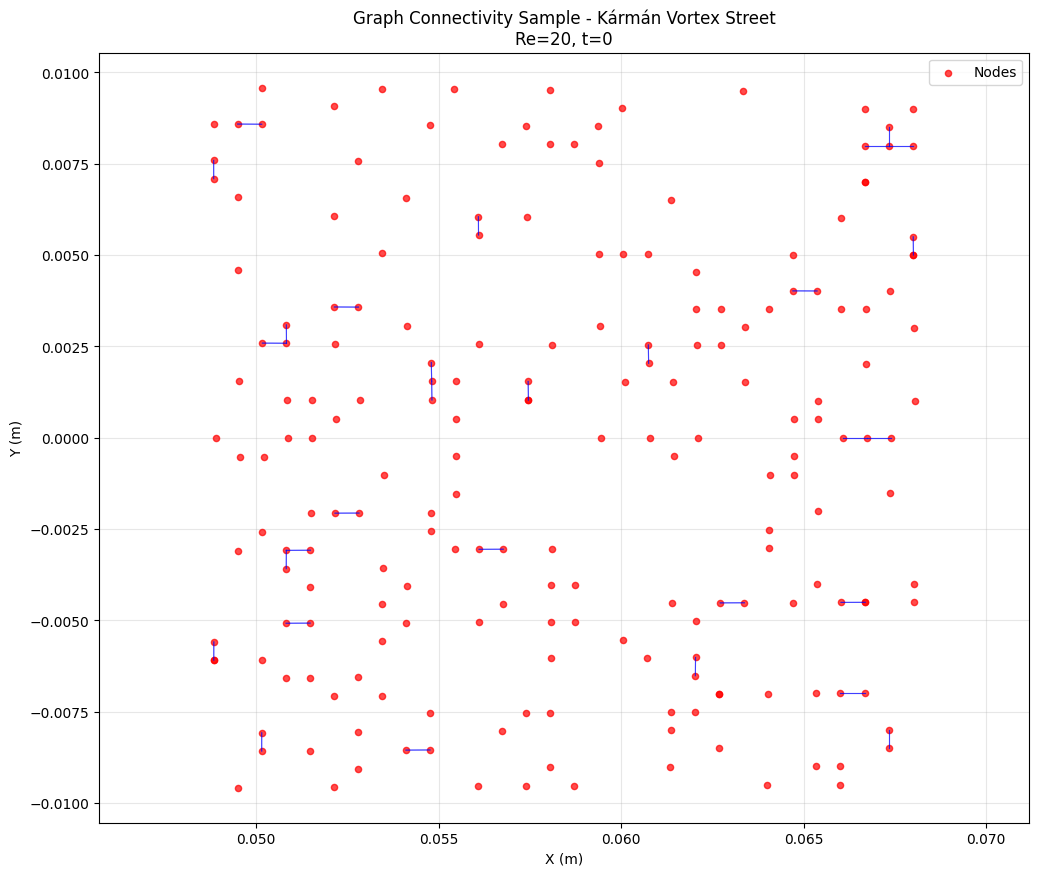

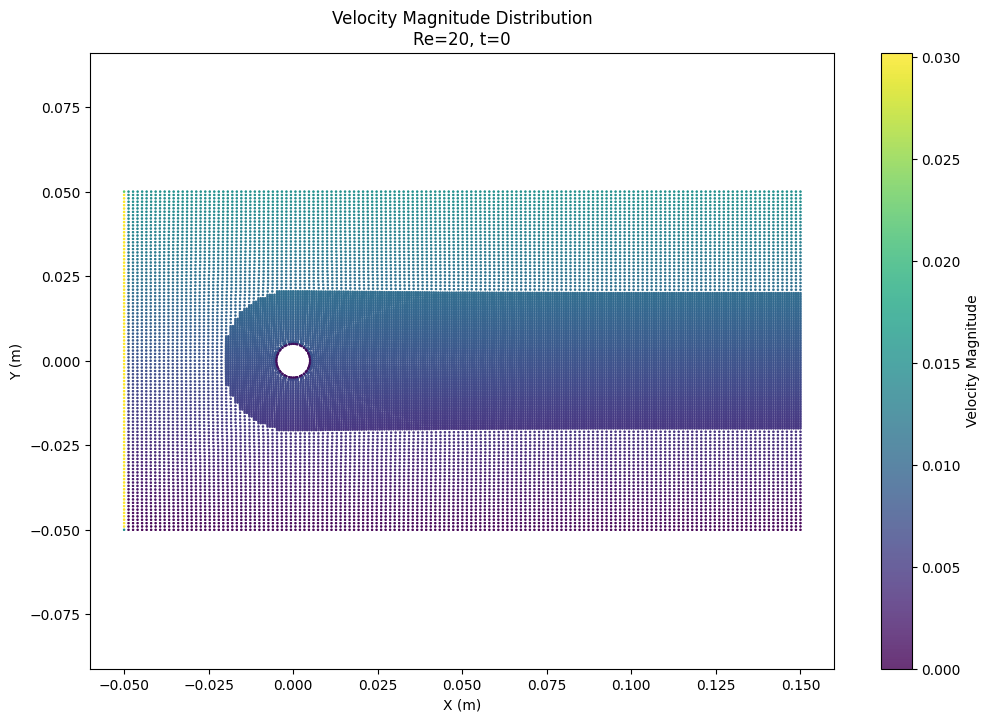

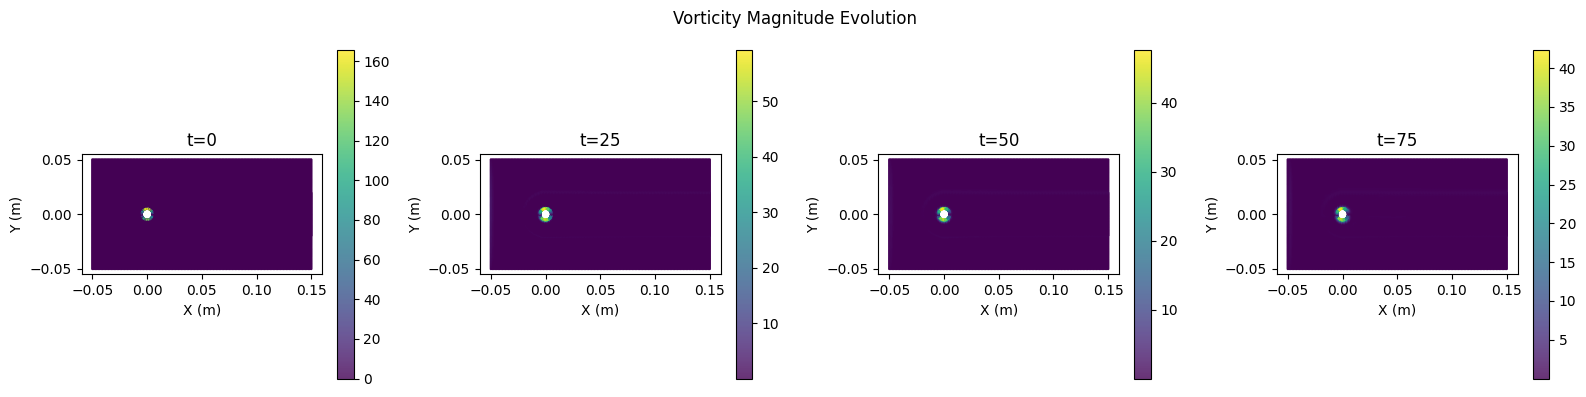

Analyzing prediction accuracy for 'velocity_magnitude'...
Sample 0: MSE=0.000490, MAE=0.021910
Sample 5: MSE=0.000000, MAE=0.000070
Sample 10: MSE=0.000000, MAE=0.000057


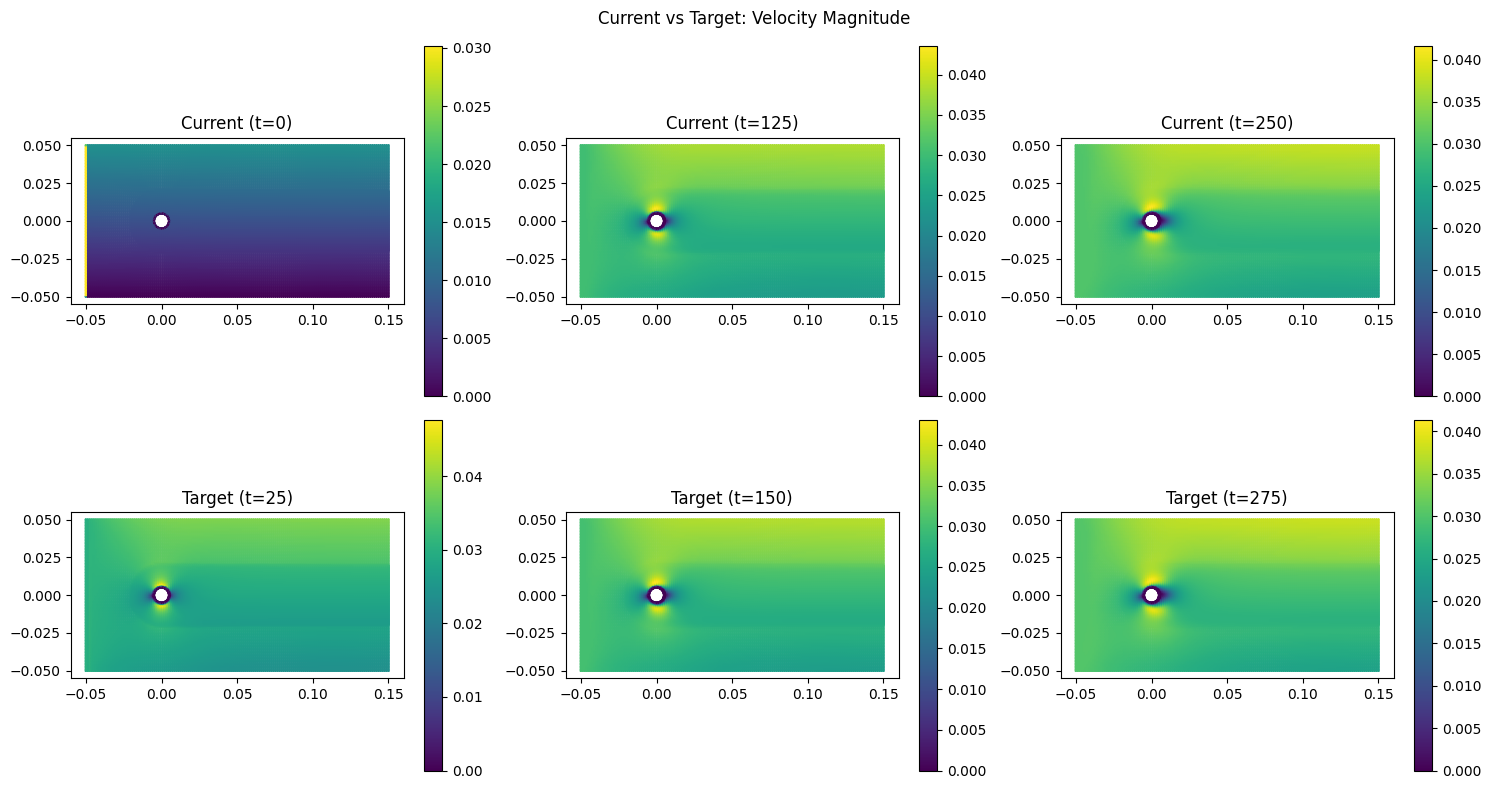

In [8]:
# Detailed step-by-step analysis
analyzer = KarmanPyGAnalyzer("/standard/sds_baek_energetic/G-PARC/Karman_Vortex_Processed/karman_re20_prediction.pt")

# 1. Overall dataset structure
analyzer.analyze_dataset_structure()

# 2. Graph connectivity analysis  
analyzer.analyze_graph_connectivity()

# 3. Visualize sample connectivity
analyzer.visualize_sample_connectivity(region_size=0.01, max_nodes=200)

# 4. Visualize feature distributions
analyzer.visualize_feature_distribution('velocity_magnitude')
analyzer.visualize_feature_distribution('vorticity_magnitude', timestep_range=[0, 1, 2, 3])

# 5. Check prediction accuracy (if prediction dataset)
analyzer.compare_prediction_accuracy(sample_indices=[0, 5, 10])

In [9]:
# Analyze features for a specific timestep
analyzer.analyze_single_timestep_features(timestep_idx=0)  # First timestep
analyzer.analyze_single_timestep_features(timestep_idx=100)  # Middle timestep
analyzer.analyze_single_timestep_features(timestep_idx=199)  # Last timestep


--- Single Timestep Feature Analysis ---
Dataset sample: 0
Timestep: 0
Reynolds number: 20

Feature              Min          Max          Mean         Std          Non-Zero  
------------------------------------------------------------------------------
pressure             0.000000     0.000000     0.000000     0.000000     0         
velocity_x           0.000000     0.030200     0.007612     0.003608     60642     
velocity_y           -0.000000    0.000000     0.000000     0.000000     32        
velocity_z           0.000000     0.000000     0.000000     0.000000     0         
vorticity_x          0.000000     0.000000     0.000000     0.000000     0         
vorticity_y          -0.000000    0.000000     0.000000     0.000000     60170     
vorticity_z          -165.644730  135.359772   -0.163637    4.349116     60154     
velocity_magnitude   0.000000     0.030200     0.007612     0.003608     60642     
vorticity_magnitude  0.000000     165.644730   0.340280     4.338870    

Showing 1000 of 60746 nodes for performance
Mesh Z-thickness: 0.010000 m


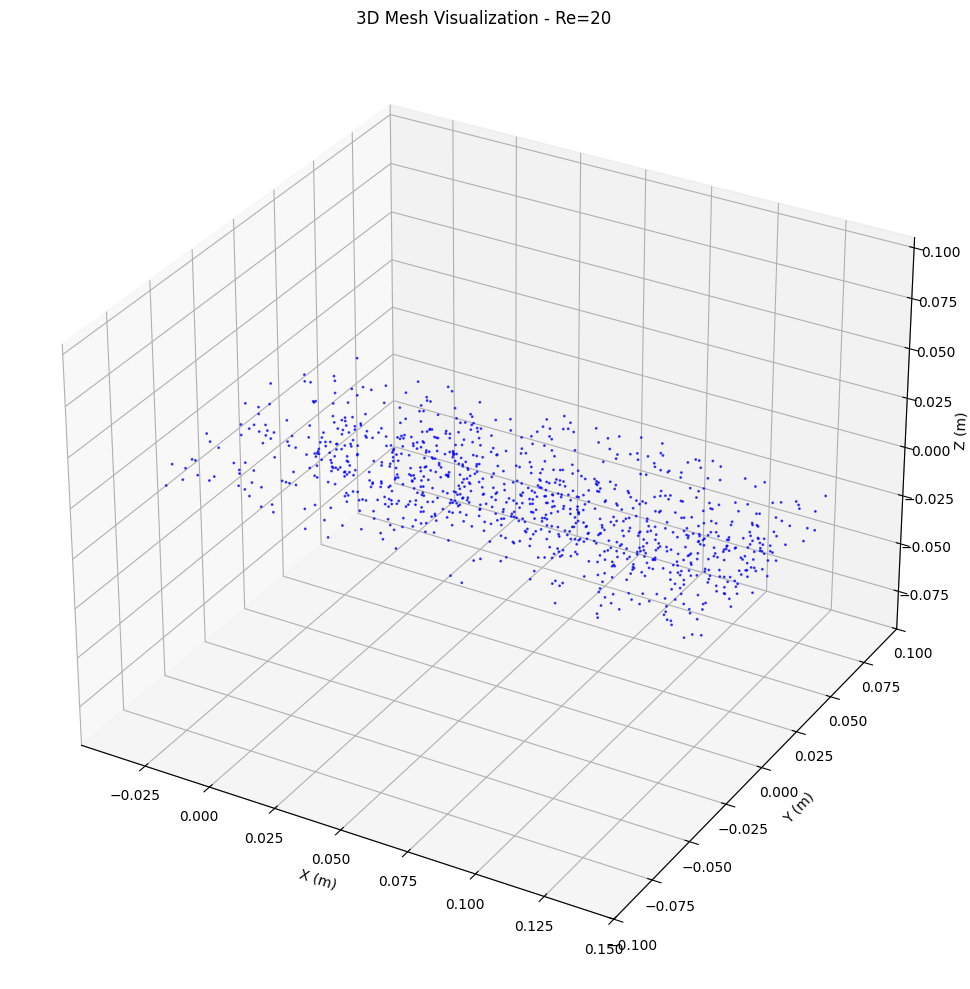


--- Z-Layer Analysis ---
Number of Z-layers: 2
Z-coordinates: [0.   0.01]
  Layer 0: z=0.000000, 30,373 nodes
  Layer 1: z=0.010000, 30,373 nodes
Showing 55000 of 60746 nodes for performance
Mesh Z-thickness: 0.010000 m


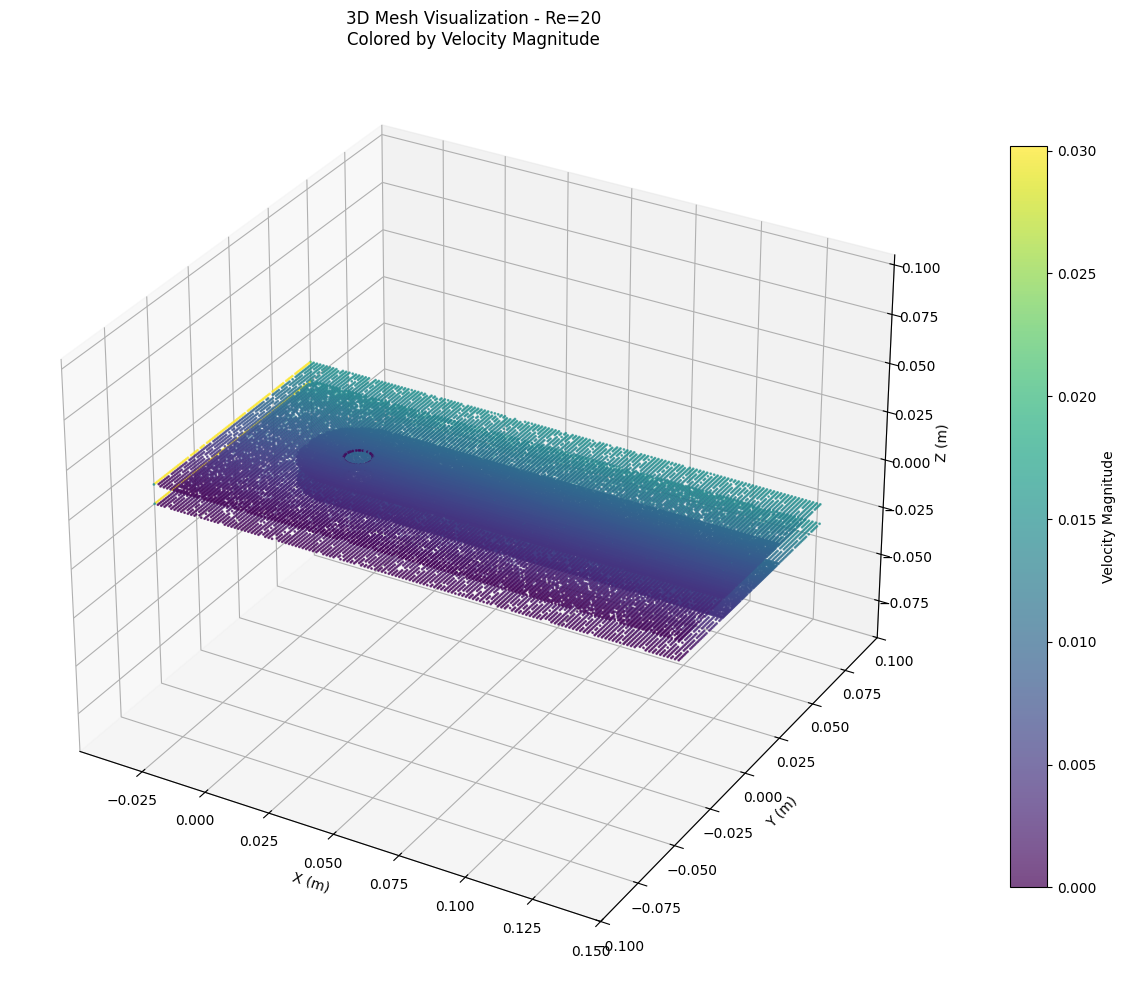


--- Z-Layer Analysis ---
Number of Z-layers: 2
Z-coordinates: [0.   0.01]
  Layer 0: z=0.000000, 30,373 nodes
  Layer 1: z=0.010000, 30,373 nodes
Showing 1000 of 60746 nodes for performance
Drew 14 edges
Mesh Z-thickness: 0.010000 m


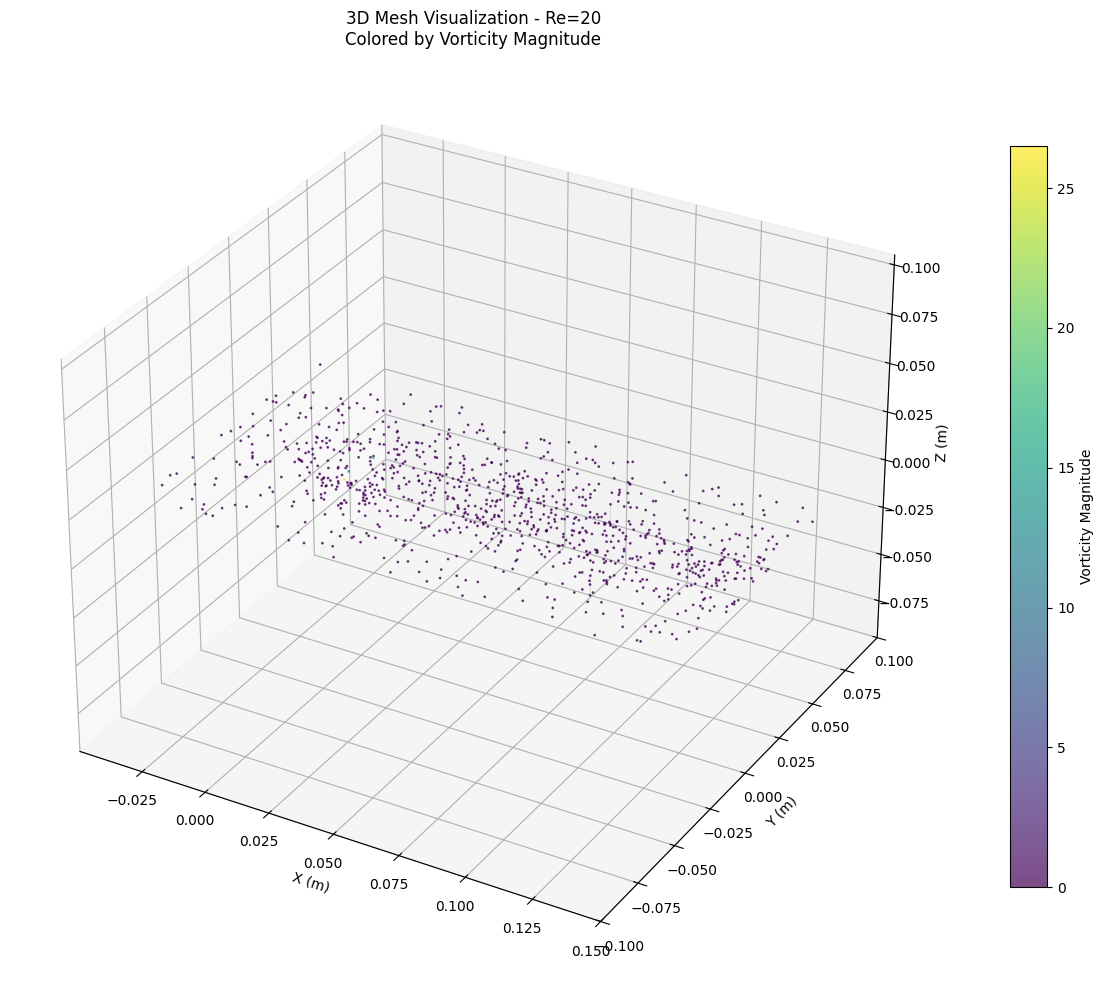


--- Z-Layer Analysis ---
Number of Z-layers: 2
Z-coordinates: [0.   0.01]
  Layer 0: z=0.000000, 30,373 nodes
  Layer 1: z=0.010000, 30,373 nodes


In [21]:
# Basic 3D mesh
analyzer.visualize_3d_mesh()

# Color by velocity magnitude
analyzer.visualize_3d_mesh(feature_name='velocity_magnitude', subsample=55000)

# Show mesh connectivity 
analyzer.visualize_3d_mesh(feature_name='vorticity_magnitude', show_edges=True, max_edges=45000)

In [16]:
# XY-plane (top view - most interesting for 2D flow)
analyzer.visualize_mesh_cross_section(plane='xy', feature_name='velocity_magnitude')

# XZ-plane (side view showing thin mesh)
analyzer.visualize_mesh_cross_section(plane='xz', feature_name='velocity_magnitude')

# YZ-plane (side view)
analyzer.visualize_mesh_cross_section(plane='yz', feature_name='velocity_magnitude')

❌ No nodes found near xy-plane at position 0.005000


IndexError: string index out of range